Disciplina: Processamento Digital de Sinais

Discentes: Eric Queiroz e Gabriel de Santana Souza



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import firwin, lfilter, butter, freqz, convolve
from IPython.display import Audio

# --- Configuração de Ambiente no Colab ---
# Se os arquivos .wav estiverem na raiz do seu Colab após o upload:
FILE_PATH = 'vozmasculina.wav'

# Se você carregou o ZIP, o caminho será:
# FILE_PATH = 'audios-teste-av3.zip/vozmasculina.wav'

Definição de Parâmetros e Funções de Cálculo

In [ ]:
# --- Parâmetros de Projeto ---
Fa = 262  # Frequência de corte inferior (Hz)
Fb = 5500 # Frequência de corte superior (Hz)
N_CHANNELS = 8 # Número de canais (Variável de análise)
ALPHA = 1.25 # Razão de Largura de Banda (pode ser ajustada)
L_BPF = 512 # Comprimento do filtro FIR Passa-Faixa (Deve ser ímpar, grande para melhor seletividade)
L_WINDOW = L_BPF # Janela para o filtro FIR
Fc_LPF = 400 # Frequência de corte do LPF para o envelope (Hz)

# Parâmetro para o filtro DC-Notch (próximo de 1 para ser estreito)
# Quanto mais 'a' se aproxima de 1, mais estreita a rejeição.
A_NOTCH = 0.99

# --- Funções para Cálculo de Bandas de Frequência ---

def calculate_cochlear_bands(N, Fa, Fb, alpha, fs):
    """Calcula larguras de banda e frequências centrais baseadas em Fa, Fb e alpha."""

    # 1. Cálculo da Largura de Banda do primeiro canal (B1)
    B1 = (Fb - Fa) * (1 - alpha) / (1 - alpha**N)

    B = np.zeros(N)
    Fc = np.zeros(N)

    # 2. Larguras de Banda Subsequentes (Bn)
    for n in range(N):
        B[n] = B1 * (alpha**n)

    # 3. Frequências Centrais (Fcn)
    Fc[0] = Fa + 0.5 * B[0]
    for n in range(1, N):
        # A frequência central é o centro do novo canal
        Fc[n] = Fc[n-1] + 0.5 * B[n-1] + 0.5 * B[n]

    # 4. Frequências de Corte (Fln, Fhn)
    Fl = Fc - B/2
    Fh = Fc + B/2

    # Normalização
    Fl_norm = Fl / (fs / 2)
    Fh_norm = Fh / (fs / 2)

    return Fl, Fh, Fc, Fl_norm, Fh_norm, B

# Função auxiliar para projetar o filtro DC-Notch IIR (Remoção de DC)
def design_dc_notch_iir(a):
    """
    Projeta o filtro DC-Notch IIR de primeira ordem:
    H(z) = (1/2)(1+a) * (1 - z^-1) / (1 - a*z^-1)
    """
    b = 0.5 * (1 + a) * np.array([1.0, -1.0]) # Numerador: 1 - z^-1
    a_coeffs = np.array([1.0, -a])             # Denominador: 1 - a*z^-1
    return b, a_coeffs

Implementação do Sistema (Função Principal)

In [ ]:
def cochlear_implant_simulator(file_path, N_channels, L_bpf, Fc_lpf, A_notch):

    # 1. Carregar o Sinal de Entrada
    fs, x = wavfile.read(file_path)

    # Normaliza o sinal para evitar clipping e converter para float
    x = x.astype(np.float64)
    if x.ndim > 1:
        x = x[:, 0] # Pega apenas um canal se for estéreo
    x /= np.max(np.abs(x))


    # 2. Definição das Frequências e Parâmetros
    Fl, Fh, Fc, Fl_norm, Fh_norm, B = calculate_cochlear_bands(N_channels, Fa, Fb, ALPHA, fs)

    # Array para armazenar o sinal de saída de cada canal
    y_mod_channels = np.zeros((N_channels, len(x)))

    # Array para armazenar o sinal final reconstruído
    y_final = np.zeros_like(x)

    print(f"Frequência de Amostragem (fs): {fs/1000:.1f} kHz")
    print(f"N Canais: {N_channels}")
    print(f"Frequências Centrais (Fc): {Fc.round(0)} Hz")

    # --- ETAPA A: FILTRO DE PRÉ-ÊNFASE ---
    # H(z) = 1 - z^-1
    b_pre = np.array([1.0, -1.0])
    y_pre = lfilter(b_pre, [1.0], x)

    # --- ETAPAS B, C e D: Banco de Canais ---
    for n in range(N_channels):

        # --- ETAPA B: Banco de Filtros Passa-Faixa (BPF) FIR ---
        # Frequências de corte para o filtro atual
        f_low = Fl[n] / (fs / 2)
        f_high = Fh[n] / (fs / 2)

        # Coeficientes do BPF FIR (usando janela de Hamming)
        # O argumento é [f_low, f_high] normalizado para Nyquist
        # O atraso é (L_BPF - 1) / 2 amostras
        h_bpf = firwin(L_bpf, [f_low, f_high], pass_zero=False, window='hamming')

        # Aplica o filtro BPF ao sinal pré-enfatizado
        y_n = convolve(y_pre, h_bpf, mode='same') # Usa 'same' para manter o mesmo comprimento e centralizar o atraso

        # --- ETAPA C: Detecção de Envoltória ---

        # 1. Retificação (Magnitude de Onda Completa)
        y_rect_n = np.abs(y_n)

        # 2. Filtro Passa-Baixa (LPF) IIR (Suavização)
        # Ajusta a frequência de corte do LPF para o envelope.
        # Fc_lpf/ (fs/2) é a frequência de corte normalizada.
        b_lpf, a_lpf = butter(4, Fc_lpf / (fs / 2), btype='low', analog=False, output='ba')
        y_lpf_n = lfilter(b_lpf, a_lpf, y_rect_n)

        # 3. Filtro DC-Notch IIR (Remoção da componente DC)
        b_notch, a_notch = design_dc_notch_iir(A_notch)
        e_n = lfilter(b_notch, a_notch, y_lpf_n) # e_n é o envelope final

        # --- ETAPA D: Modulação e Soma ---

        # 1. Geração da Senoide Portadora (na frequência central Fc)
        t = np.arange(len(x)) / fs
        carrier_n = np.cos(2 * np.pi * Fc[n] * t)

        # 2. Modulação (Envelope * Portadora)
        y_mod_n = e_n * carrier_n

        # 3. Soma
        y_final += y_mod_n
        y_mod_channels[n, :] = y_mod_n

    # --- 4. Normalização da Saída ---
    y_final /= np.max(np.abs(y_final))

    return fs, x, y_pre, y_final, y_mod_channels, Fl, Fh, Fc

# Função para Visualização
def plot_analysis(fs, x, y_pre, y_final, Fc, title):

    plt.figure(figsize=(15, 10))

    # Espectrograma do Sinal Original
    plt.subplot(3, 1, 1)
    plt.specgram(x, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
    plt.title(f'{title} - Sinal Original')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.colorbar(label='Potência (dB)')

    # Espectrograma do Sinal Pré-Enfatizado (Referência para comparação)
    plt.subplot(3, 1, 2)
    plt.specgram(y_pre, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
    plt.title(f'{title} - Sinal Pré-Enfatizado')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.colorbar(label='Potência (dB)')

    # Espectrograma do Sinal Reconstruído (Saída Final)
    plt.subplot(3, 1, 3)
    plt.specgram(y_final, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
    # Adicionar linhas para as frequências centrais
    for fc in Fc:
        plt.axhline(fc, color='r', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.title(f'{title} - Saída Reconstruída ({len(Fc)} Canais)')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.colorbar(label='Potência (dB)')
    plt.tight_layout()
    plt.show()

##Execução, Análise e Verificação

Funções de Análise e Execução

In [ ]:
# --- IMPORTS ADICIONAIS NECESSÁRIOS ---
# Certifique-se de que os imports do Passo 0 (numpy, matplotlib, scipy.io, scipy.signal, IPython.display)
# da resposta anterior estejam ativos.

# Função para realizar a análise de desempenho comparativa
def comparative_performance_analysis(file_path, channel_list, L_bpf, Fc_lpf, A_notch):
    """
    Executa a simulação para diferentes números de canais e plota os resultados.

    Args:
        file_path (str): Caminho do arquivo de áudio de entrada.
        channel_list (list): Lista de número de canais (e.g., [4, 8, 12]).
        ... (outros parâmetros do simulador)
    """

    print("\n========================================================")
    print(f"ANÁLISE COMPARATIVA: Variação de Canais ({file_path.split('/')[-1]})")
    print("========================================================\n")

    # Plota o espectrograma do sinal pré-enfatizado (o mesmo para todos)
    fs, x, y_pre, _, _, _, _, _ = cochlear_implant_simulator(
        file_path, channel_list[0], L_bpf, Fc_lpf, A_notch)

    plt.figure(figsize=(15, 10))
    plt.subplot(len(channel_list) + 1, 1, 1)
    plt.specgram(y_pre, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
    plt.title(f'Sinal Pré-Enfatizado (Referência)')
    plt.ylabel('Frequência (Hz)')
    plt.colorbar(label='Potência (dB)')

    # Executa e plota para cada número de canal
    for i, N in enumerate(channel_list):
        print(f"Executando simulação para N = {N} canais...")
        fs, _, _, y_final, _, _, _, Fc = cochlear_implant_simulator(
            file_path, N, L_bpf, Fc_lpf, A_notch)

        # Plota o espectrograma da saída reconstruída
        plt.subplot(len(channel_list) + 1, 1, i + 2)
        plt.specgram(y_final, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')

        # Adiciona linhas das frequências centrais
        for fc in Fc:
            plt.axhline(fc, color='r', linestyle='--', linewidth=0.5, alpha=0.7)

        plt.title(f'Saída Reconstruída com N = {N} Canais')
        plt.ylabel('Frequência (Hz)')
        plt.colorbar(label='Potência (dB)')

        # Reprodução de áudio para comparação auditiva
        print(f"Saída de Áudio N={N} Canais:")
        display(Audio(y_final, rate=fs))

    plt.xlabel('Tempo (s)')
    plt.tight_layout()
    plt.show()

# Função para realizar o teste de verificação com senoide
def sinusoid_verification_test(N_channels, L_bpf, Fc_lpf, A_notch, duration=2.0):
    """
    Gera uma senoide na frequência central do primeiro canal e a usa como entrada.

    Args:
        N_channels (int): Número de canais a ser usado na simulação.
        duration (float): Duração da senoide em segundos.
        ... (outros parâmetros do simulador)
    """

    print("\n========================================================")
    print("TESTE DE VERIFICAÇÃO: Senoide no Canal 1")
    print("========================================================\n")

    # Parâmetros de amostragem padrão
    fs = 22050

    # 1. Cálculo das frequências para obter a frequência central f_c1
    _, _, Fc, _, _, _ = calculate_cochlear_bands(N_channels, Fa, Fb, ALPHA, fs)
    Fc1 = Fc[0] # Frequência central do primeiro canal

    # 2. Geração da Senoide de Teste
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    x_senoide = 0.5 * np.sin(2 * np.pi * Fc1 * t) # Senoide na frequência central f_c1

    # 3. Simulação
    # O simulador precisa de um 'file_path' na assinatura, mas vamos passar 'None' e ajustar a função
    # Para rodar no Colab de forma prática, vamos criar um arquivo temporário ou modificar a função principal.

    # Para simplificar, vou adaptar o `cochlear_implant_simulator` para aceitar um array de sinal.
    # ***NOTA: Para este código funcionar, você precisará adaptar a função cochlear_implant_simulator para que ela não dependa da leitura de arquivo, aceitando 'x' e 'fs' diretamente.***

    # Alternativa mais simples (e suja) para fins de demonstração no Colab:
    wavfile.write('temp_senoide.wav', fs, x_senoide.astype(np.float32))

    fs_out, x_orig, y_pre_out, y_final_out, y_mod_channels_out, _, _, Fc_out = cochlear_implant_simulator(
        file_path='temp_senoide.wav', N_channels=N_channels, L_bpf=L_bpf, Fc_lpf=Fc_lpf, A_notch=A_notch)

    print(f"Frequência Central do Canal 1: {Fc1:.2f} Hz")
    print(f"Frequência da Senoide de Teste: {Fc1:.2f} Hz")

    # 4. Visualização e Verificação
    plt.figure(figsize=(15, 6))

    # Espectrograma da Saída Reconstruída
    plt.subplot(2, 1, 1)
    plt.specgram(y_final_out, NFFT=1024, Fs=fs_out, noverlap=512, cmap='viridis')
    # Corrected label for Hz
    plt.axhline(Fc1, color='red', linestyle='-', linewidth=2, label=rf'$f_{{c1}} = {Fc1:.2f} 	ext{{ Hz}}$')
    plt.title(f'Saída Reconstruída (N={N_channels}) - Teste de Senoide em $f_{{c1}}$')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.legend()
    plt.colorbar(label='Potência (dB)')

    # Visualização Temporal do Canal 1 (Onde a energia deve estar concentrada)
    plt.subplot(2, 1, 2)
    plt.plot(t, y_mod_channels_out[0, :], label='Saída Modulada do Canal 1')
    plt.title('Saída Temporal do Canal 1')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    print("\nSaída de Áudio (Reconstruído):")
    display(Audio(y_final_out, rate=fs_out))

Execução das Análises

In [ ]:
# --- EXECUÇÃO DAS ANÁLISES ---
import os
import zipfile

# --- Configuração de Caminhos e Descompactação ---
zip_file_name = 'audios-teste-av3.zip'
# List all files expected to be in the current directory after extraction
expected_audio_files = ['vozmasculina.wav', 'vozfeminina.wav', 'instrumento.wav']

print(f"Verificando e descompactando {zip_file_name}...")
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Check if files already exist to avoid unnecessary re-extraction
        for member in expected_audio_files:
            if not os.path.exists(member):
                zip_ref.extract(member, './') # Extract to current directory
                print(f"Conteúdo de '{member}' extraído com sucesso.")
            else:
                print(f"Arquivo '{member}' já existe.")

except FileNotFoundError:
    print(f"Erro: O arquivo ZIP '{zip_file_name}' não foi encontrado. Por favor, faça o upload do arquivo.")
except zipfile.BadZipFile:
    print(f"Erro: '{zip_file_name}' não é um arquivo ZIP válido.")

# Ensure FILE_FEMALE_SPEECH and FILE_INSTRUMENT are defined for subsequent cells
FILE_FEMALE_SPEECH = 'vozfeminina.wav'
FILE_INSTRUMENT = 'instrumento.wav'

# Parâmetros de Teste
FILE_SPEECH = 'vozmasculina.wav' # Now should correctly refer to the extracted file
CHANNEL_LIST = [4, 8, 12] # Lista de canais para análise comparativa
N_TESTE_SENOIDE = 8 # Número de canais para o teste de senoide

# 1. Análise Comparativa de Desempenho (Variação de Canais)
# Analise a voz masculina com 4, 8 e 12 canais.
comparative_performance_analysis(
    file_path=FILE_SPEECH,
    channel_list=CHANNEL_LIST,
    L_bpf=L_BPF,
    Fc_lpf=Fc_LPF,
    A_notch=A_NOTCH
)

# 2. Teste de Senoide (Verificação do Sistema)
# Teste se uma senoide em Fc1 é bem reconstruída.
sinusoid_verification_test(
    N_channels=N_TESTE_SENOIDE,
    L_bpf=L_BPF,
    Fc_lpf=Fc_LPF,
    A_notch=A_NOTCH
)

Verificando e descompactando audios-teste-av3.zip...
Arquivo 'vozmasculina.wav' já existe.
Arquivo 'vozfeminina.wav' já existe.
Arquivo 'instrumento.wav' já existe.


NameError: name 'comparative_performance_analysis' is not defined


########################################################
INICIANDO ANÁLISE DE DESEMPENHO: VOZ FEMININA
########################################################

ANÁLISE COMPARATIVA: Variação de Canais (vozfeminina.wav)

Frequência de Amostragem (fs): 22.1 kHz
N Canais: 4
Frequências Centrais (Fc): [ 716. 1738. 3016. 4613.] Hz
Executando simulação para N = 4 canais...
Frequência de Amostragem (fs): 22.1 kHz
N Canais: 4
Frequências Centrais (Fc): [ 716. 1738. 3016. 4613.] Hz
Saída de Áudio N=4 Canais:


Executando simulação para N = 8 canais...
Frequência de Amostragem (fs): 22.1 kHz
N Canais: 8
Frequências Centrais (Fc): [ 394.  691. 1062. 1526. 2106. 2831. 3738. 4871.] Hz
Saída de Áudio N=8 Canais:


Executando simulação para N = 12 canais...
Frequência de Amostragem (fs): 22.1 kHz
N Canais: 12
Frequências Centrais (Fc): [ 310.  419.  555.  725.  937. 1202. 1534. 1949. 2467. 3115. 3925. 4938.] Hz
Saída de Áudio N=12 Canais:


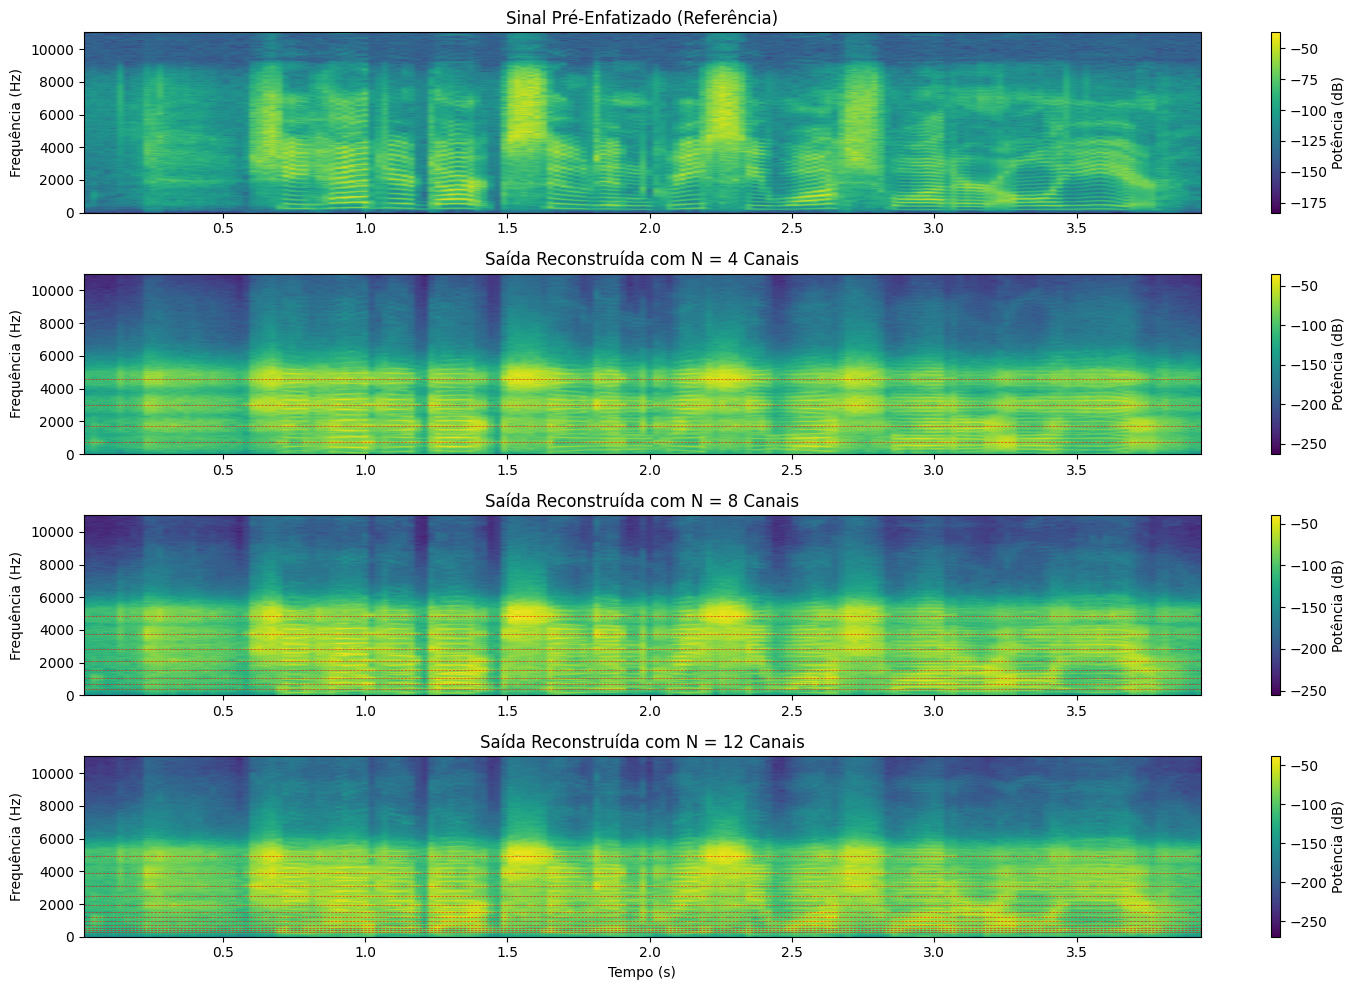


########################################################
INICIANDO ANÁLISE DE DESEMPENHO: INSTRUMENTO (MÚSICA)
########################################################

ANÁLISE COMPARATIVA: Variação de Canais (instrumento.wav)

Frequência de Amostragem (fs): 22.1 kHz
N Canais: 4
Frequências Centrais (Fc): [ 716. 1738. 3016. 4613.] Hz
Executando simulação para N = 4 canais...
Frequência de Amostragem (fs): 22.1 kHz
N Canais: 4
Frequências Centrais (Fc): [ 716. 1738. 3016. 4613.] Hz
Saída de Áudio N=4 Canais:


Executando simulação para N = 8 canais...
Frequência de Amostragem (fs): 22.1 kHz
N Canais: 8
Frequências Centrais (Fc): [ 394.  691. 1062. 1526. 2106. 2831. 3738. 4871.] Hz
Saída de Áudio N=8 Canais:


Executando simulação para N = 12 canais...
Frequência de Amostragem (fs): 22.1 kHz
N Canais: 12
Frequências Centrais (Fc): [ 310.  419.  555.  725.  937. 1202. 1534. 1949. 2467. 3115. 3925. 4938.] Hz
Saída de Áudio N=12 Canais:


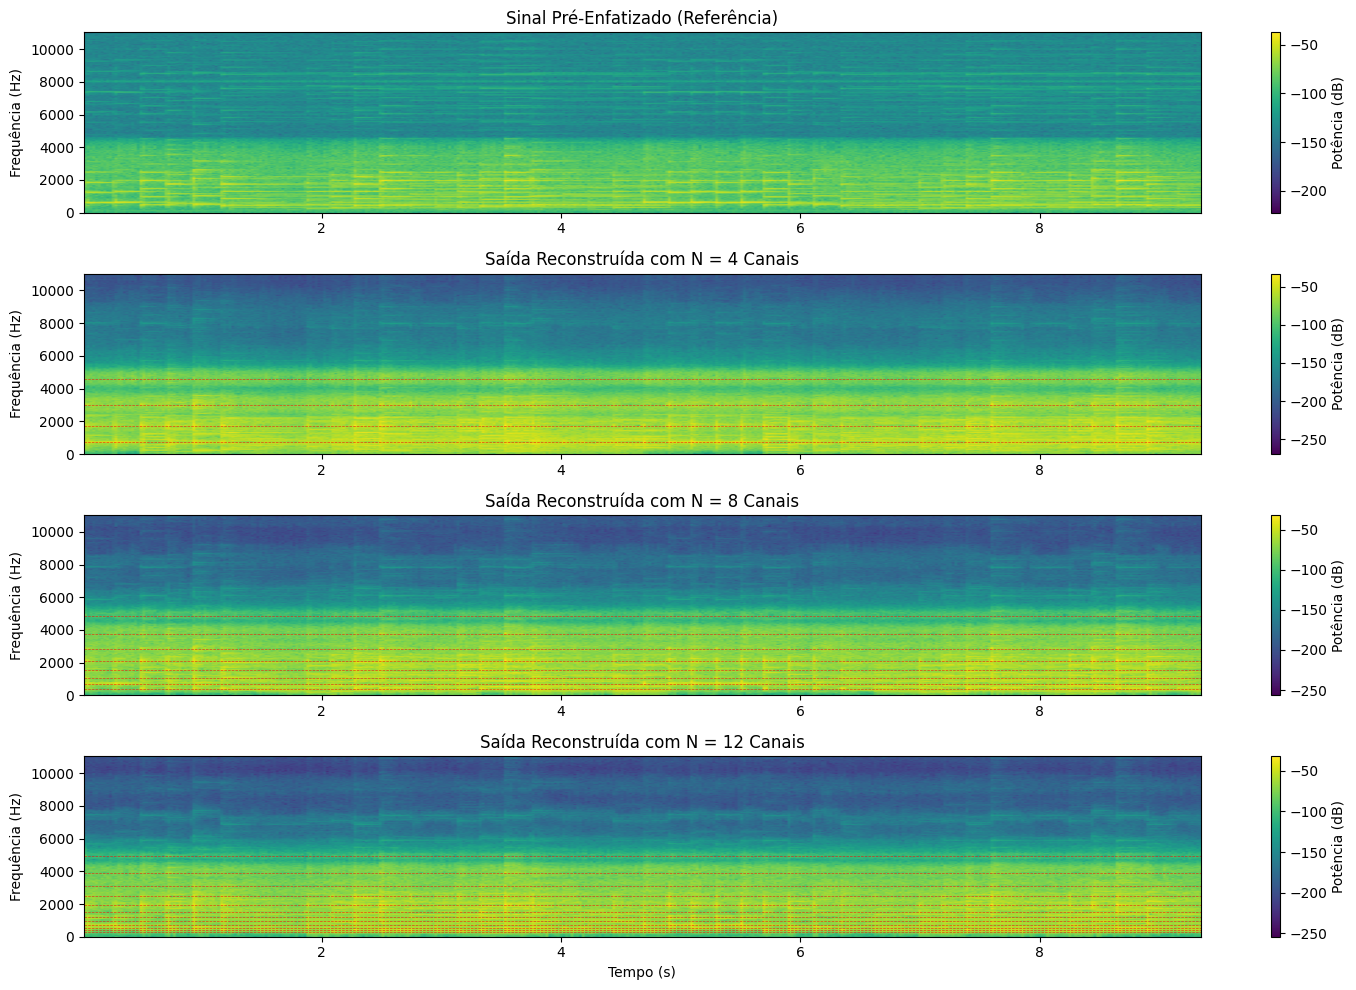


########################################################
INICIANDO TESTE DE VERIFICAÇÃO: SENOIDE
########################################################

TESTE DE VERIFICAÇÃO: Senoide no Canal 1

Frequência de Amostragem (fs): 22.1 kHz
N Canais: 8
Frequências Centrais (Fc): [ 394.  691. 1062. 1526. 2106. 2831. 3738. 4871.] Hz
Frequência Central do Canal 1: 393.99 Hz
Frequência da Senoide de Teste: 393.99 Hz


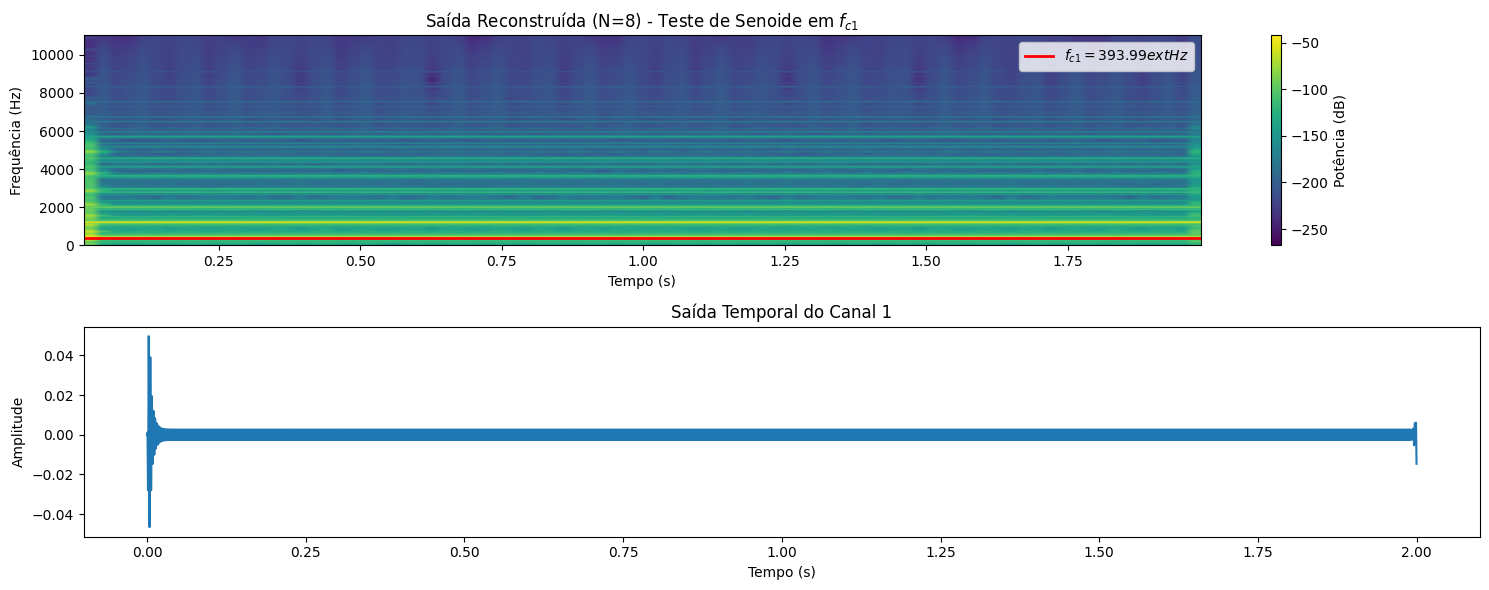


Saída de Áudio (Reconstruído):


In [ ]:
# --- PARÂMETROS GLOBAIS (Manter os valores definidos anteriormente) ---
# Fa = 262
# Fb = 5500
# ALPHA = 1.25
# L_BPF = 512
# Fc_LPF = 400
# A_NOTCH = 0.99
CHANNEL_LIST = [4, 8, 12] # Lista de canais para análise comparativa
N_TESTE_SENOIDE = 8 # Número de canais para o teste de senoide

# Arquivos de áudio (Certifique-se que o caminho está correto)
FILE_FEMALE_SPEECH = 'vozfeminina.wav'
FILE_INSTRUMENT = 'instrumento.wav'

# --- 1. ANÁLISE COMPARATIVA: VOZ FEMININA (Variação de Canais) ---
print("\n########################################################")
print("INICIANDO ANÁLISE DE DESEMPENHO: VOZ FEMININA")
print("########################################################")

comparative_performance_analysis(
    file_path=FILE_FEMALE_SPEECH,
    channel_list=CHANNEL_LIST,
    L_bpf=L_BPF,
    Fc_lpf=Fc_LPF,
    A_notch=A_NOTCH
)


# --- 2. ANÁLISE COMPARATIVA: INSTRUMENTO/MÚSICA (Variação de Canais) ---
print("\n########################################################")
print("INICIANDO ANÁLISE DE DESEMPENHO: INSTRUMENTO (MÚSICA)")
print("########################################################")

comparative_performance_analysis(
    file_path=FILE_INSTRUMENT,
    channel_list=CHANNEL_LIST,
    L_bpf=L_BPF,
    Fc_lpf=Fc_LPF,
    A_notch=A_NOTCH
)


# --- 3. TESTE DE VERIFICAÇÃO: SENOIDE (Manter para comprovação) ---
# Este teste não depende do arquivo de áudio, mas sim da frequência central calculada.
print("\n########################################################")
print("INICIANDO TESTE DE VERIFICAÇÃO: SENOIDE")
print("########################################################")

sinusoid_verification_test(
    N_channels=N_TESTE_SENOIDE,
    L_bpf=L_BPF,
    Fc_lpf=Fc_LPF,
    A_notch=A_NOTCH
)

Definição da Função de Análise de Resposta em Frequência

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# --- Parâmetros (Manter consistentes com a simulação) ---
Fa = 262
Fb = 5500
N_CHANNELS = 8
ALPHA = 1.25
L_BPF = 512
FS = 22050  # Frequência de amostragem (Hz)

# Função para cálculo das bandas (reutilizada do passo anterior)
def calculate_cochlear_bands(N, Fa, Fb, alpha, fs):
    """Calcula larguras de banda e frequências centrais."""
    B1 = (Fb - Fa) * (1 - alpha) / (1 - alpha**N)
    B = np.zeros(N)
    Fc = np.zeros(N)

    for n in range(N):
        B[n] = B1 * (alpha**n)

    Fc[0] = Fa + 0.5 * B[0]
    for n in range(1, N):
        Fc[n] = Fc[n-1] + 0.5 * B[n-1] + 0.5 * B[n]

    Fl = Fc - B/2
    Fh = Fc + B/2

    Fl_norm = Fl / (fs / 2)
    Fh_norm = Fh / (fs / 2)

    return Fl, Fh, Fc, Fl_norm, Fh_norm, B

# --- NOVA FUNÇÃO PARA PLOTAR DOCUMENTAÇÃO DE DESIGN ---

def design_analysis_plots(N_channels, L_bpf, fs):

    # 1. Cálculo das Frequências
    Fl, Fh, Fc, Fl_norm, Fh_norm, B = calculate_cochlear_bands(N_channels, Fa, Fb, ALPHA, fs)

    # Inicializa um array para armazenar o módulo de H(jw) para cada canal
    H_mag_all = []

    # --- Loop para projetar e analisar cada filtro ---
    plt.figure(figsize=(15, 12))

    for n in range(N_channels):

        f_low = Fl[n] / (fs / 2)
        f_high = Fh[n] / (fs / 2)

        # Coeficientes do BPF FIR (usando janela de Hamming)
        h_bpf = firwin(L_bpf, [f_low, f_high], pass_zero=False, window='hamming')

        # Calcular Resposta em Frequência (usando 5000 pontos para alta resolução)
        # O segundo argumento '1' é para o denominador (IIR seria [1, a1, a2, ...])
        w, H = freqz(h_bpf, 1, worN=5000)

        # Converte frequência angular normalizada (rad/amostra) para Hertz
        f = w * fs / (2 * np.pi)

        # Armazena a magnitude para o gráfico de soma
        H_mag_all.append(np.abs(H))

        # Plot 1: Resposta em Magnitude (dB) - Todos os Canais
        plt.subplot(3, 1, 1)
        plt.plot(f, 20 * np.log10(np.abs(H)), label=f'Canal {n+1} (Fc={Fc[n]:.0f} Hz)')

        # Plot 2: Resposta em Fase (Graus) - Todos os Canais
        # O filtro FIR de fase linear tem fase linearmente decrescente
        plt.subplot(3, 1, 2)
        # np.unwrap desfaz o 'dobramento' da fase em +/- pi
        phase = np.unwrap(np.angle(H))
        # Converte para graus
        plt.plot(f, phase * 180/np.pi, label=f'Canal {n+1}')


    # --- Plot 1 Configurações (Magnitude) ---
    plt.subplot(3, 1, 1)
    plt.title(f'Resposta em Magnitude do Banco de Filtros FIR (N={N_channels})')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(0, Fb + 500) # Exibe até o limite superior + um pouco
    plt.ylim(-60, 5) # De -60dB até 5dB para ver os picos
    plt.legend(ncol=4, fontsize='small')


    # --- Plot 2 Configurações (Fase) ---
    plt.subplot(3, 1, 2)
    plt.title(f'Resposta em Fase Linear (Filtros FIR de N={N_channels})')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Fase (Graus)')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(0, Fb + 500)


    # --- Plot 3: Soma das Magnitudes (Teste de Soma ≈ 1) ---
    H_mag_sum = np.sum(np.array(H_mag_all), axis=0)
    plt.subplot(3, 1, 3)
    plt.plot(f, H_mag_sum, color='blue', linewidth=2)
    plt.axhline(1.0, color='red', linestyle='--', label='Ideal: Magnitude = 1')

    plt.title('Soma das Respostas em Magnitude (Condição de Reconstrução)')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Soma da Magnitude (|ΣHn(ejw)|)')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(0, Fb + 500)
    plt.ylim(np.max([0.5, np.min(H_mag_sum)]) - 0.1, np.max(H_mag_sum) + 0.1)
    plt.legend()

    plt.tight_layout()
    plt.show()

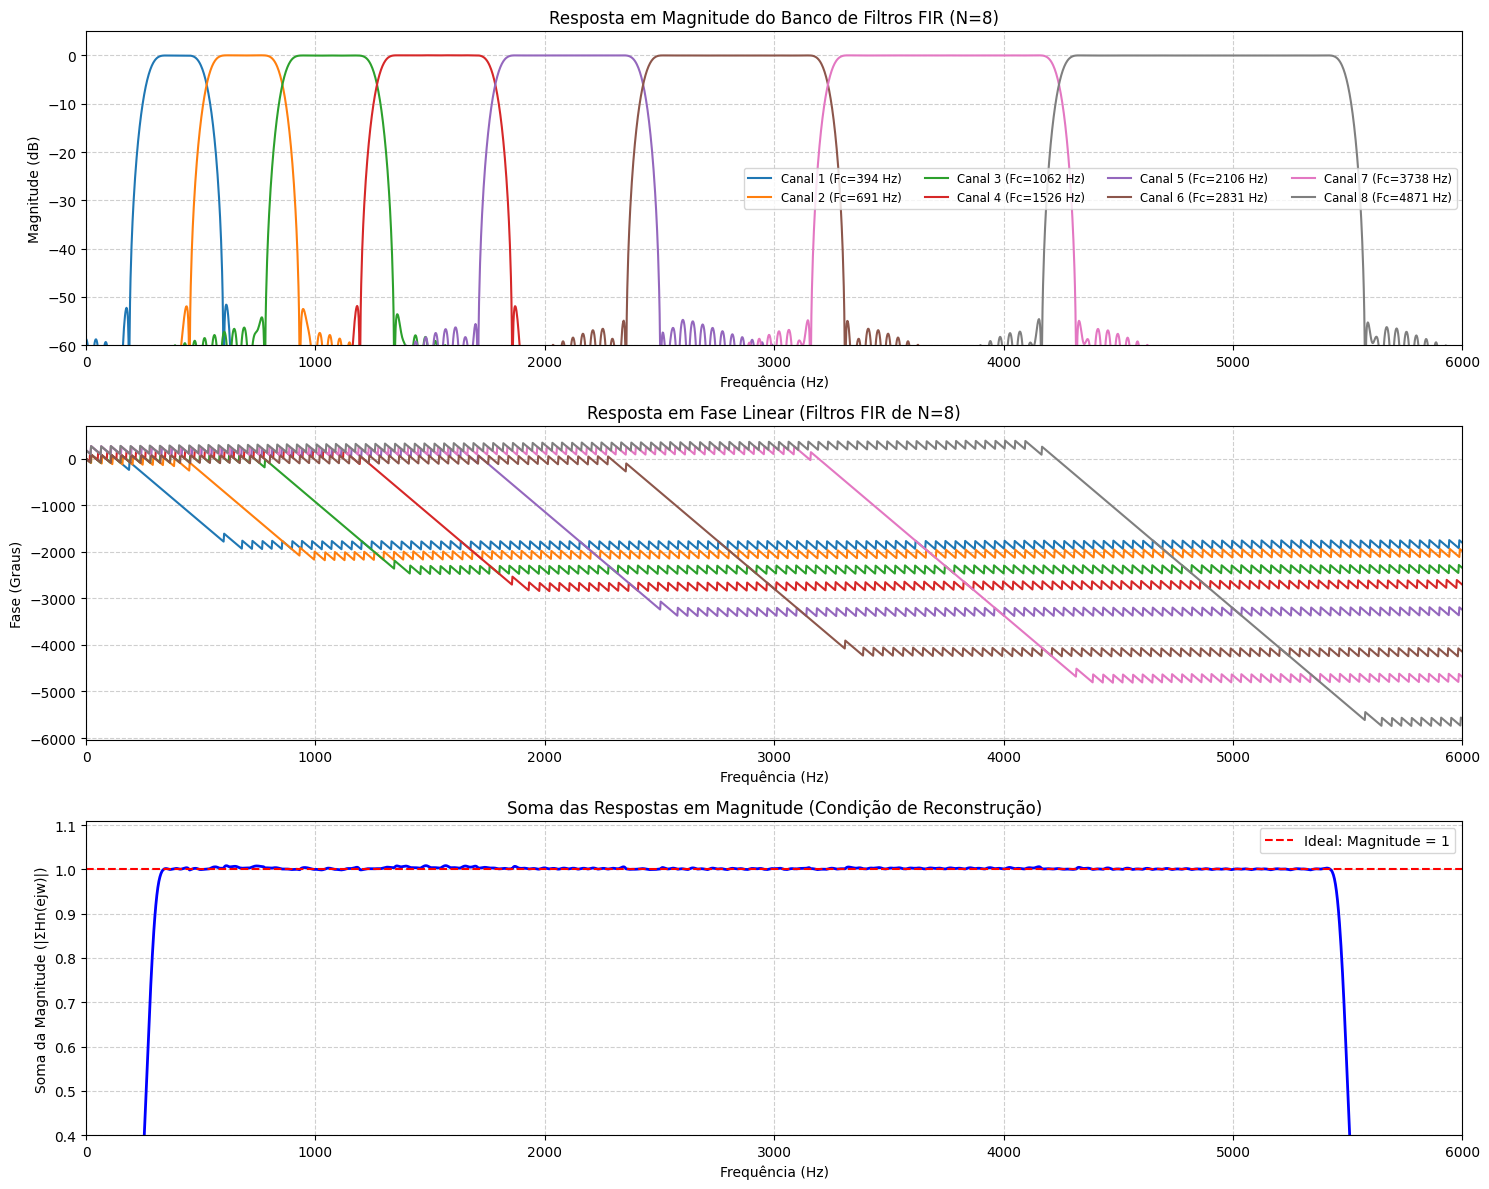

In [ ]:
# --- EXECUÇÃO PARA GERAÇÃO DOS GRÁFICOS DE DOCUMENTAÇÃO ---

# Executa a função para o caso de 8 canais e o filtro de 512 taps
design_analysis_plots(
    N_channels=N_CHANNELS,
    L_bpf=L_BPF,
    fs=FS
)

Geração de Coeficientes e Especificações

In [ ]:
import numpy as np
from scipy.signal import firwin
# Reutilizando parâmetros e a função calculate_cochlear_bands (definidos anteriormente)

Fa = 262
Fb = 5500
N_CHANNELS = 8
ALPHA = 1.25
L_BPF = 512
FS = 22050
# Lembre-se: A_NOTCH = 0.99 para o filtro DC-Notch

def generate_design_documentation(N_channels, L_bpf, fs):

    Fl, Fh, Fc, Fl_norm, Fh_norm, B = calculate_cochlear_bands(N_channels, Fa, Fb, ALPHA, fs)

    # 1. Tabela de Especificações
    print("\n========================================================")
    print("1. TABELA DE ESPECIFICAÇÕES DO BANCO DE FILTROS (N=8)")
    print("========================================================\n")
    print(f"{'Canal':<6}{'Fc (Hz)':<10}{'B (Hz)':<10}{'Fl (Hz)':<10}{'Fh (Hz)':<10}")
    print("-" * 46)
    for n in range(N_channels):
        print(f"{n+1:<6}{Fc[n]:<10.2f}{B[n]:<10.2f}{Fl[n]:<10.2f}{Fh[n]:<10.2f}")

    # 2. Coeficientes de Exemplo (h_n)
    print("\n========================================================")
    print("2. COEFICIENTES DO FILTRO (Exemplo: Canal 1 e Canal 8)")
    print("========================================================\n")

    # Coeficientes do Canal 1 (Baixa Frequência)
    f_low_c1 = Fl[0] / (fs / 2)
    f_high_c1 = Fh[0] / (fs / 2)
    h_c1 = firwin(L_bpf, [f_low_c1, f_high_c1], pass_zero=False, window='hamming')

    print(f"** Canal 1 (Fc={Fc[0]:.2f} Hz, B={B[0]:.2f} Hz) - L={L_bpf} Taps **")
    # Imprime os primeiros 5 e últimos 5 coeficientes (para economizar espaço)
    print(f"Primeiros 5 coeficientes (h_0 a h_4): {h_c1[:5]}")
    print(f"Coeficiente Central (h_{L_bpf//2}): {h_c1[L_bpf//2]:.6f}")
    print(f"Últimos 5 coeficientes (h_{L_bpf-5} a h_{L_bpf-1}): {h_c1[-5:]}\n")

    # Coeficientes do Canal 8 (Alta Frequência)
    f_low_c8 = Fl[7] / (fs / 2)
    f_high_c8 = Fh[7] / (fs / 2)
    h_c8 = firwin(L_bpf, [f_low_c8, f_high_c8], pass_zero=False, window='hamming')

    print(f"** Canal 8 (Fc={Fc[7]:.2f} Hz, B={B[7]:.2f} Hz) - L={L_bpf} Taps **")
    print(f"Primeiros 5 coeficientes (h_0 a h_4): {h_c8[:5]}")
    print(f"Coeficiente Central (h_{L_bpf//2}): {h_c8[L_bpf//2]:.6f}")
    print(f"Últimos 5 coeficientes (h_{L_bpf-5} a h_{L_bpf-1}): {h_c8[-5:]}\n")

# Execute a função para gerar a documentação
generate_design_documentation(N_CHANNELS, L_BPF, FS)


1. TABELA DE ESPECIFICAÇÕES DO BANCO DE FILTROS (N=8)

Canal Fc (Hz)   B (Hz)    Fl (Hz)   Fh (Hz)   
----------------------------------------------
1     393.99    263.99    262.00    525.99    
2     690.98    329.98    525.99    855.97    
3     1062.21   412.48    855.97    1268.45   
4     1526.25   515.60    1268.45   1784.05   
5     2106.30   644.50    1784.05   2428.55   
6     2831.37   805.63    2428.55   3234.18   
7     3737.69   1007.03   3234.18   4241.21   
8     4870.61   1258.79   4241.21   5500.00   

2. COEFICIENTES DO FILTRO (Exemplo: Canal 1 e Canal 8)

** Canal 1 (Fc=393.99 Hz, B=263.99 Hz) - L=512 Taps **
Primeiros 5 coeficientes (h_0 a h_4): [3.35755005e-05 2.80670228e-05 2.16428354e-05 1.45459823e-05
 7.03674014e-06]
Coeficiente Central (h_256): 0.023867
Últimos 5 coeficientes (h_507 a h_511): [7.03674014e-06 1.45459823e-05 2.16428354e-05 2.80670228e-05
 3.35755005e-05]

** Canal 8 (Fc=4870.61 Hz, B=1258.79 Hz) - L=512 Taps **
Primeiros 5 coeficientes (h_0 a 

## Documentação dos Filtros Auxiliares

Funções de Análise e Plot


GERAÇÃO DE GRÁFICOS DE DOCUMENTAÇÃO DE FILTROS AUXILIARES



/tmp/ipython-input-862549880.py:44: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 20 * np.log10(np.abs(H)))


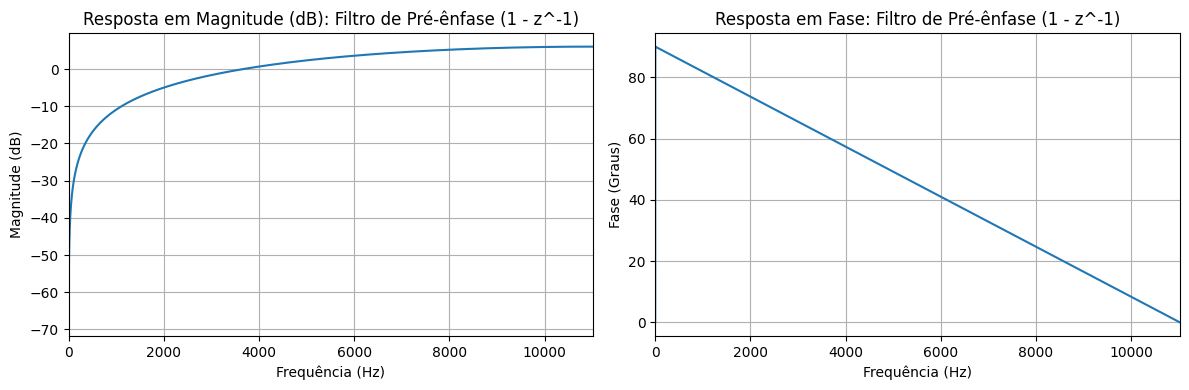

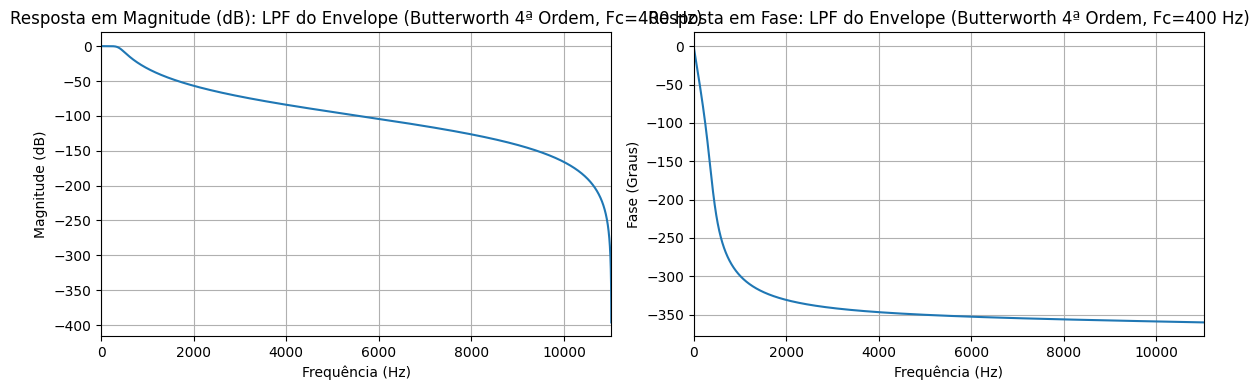

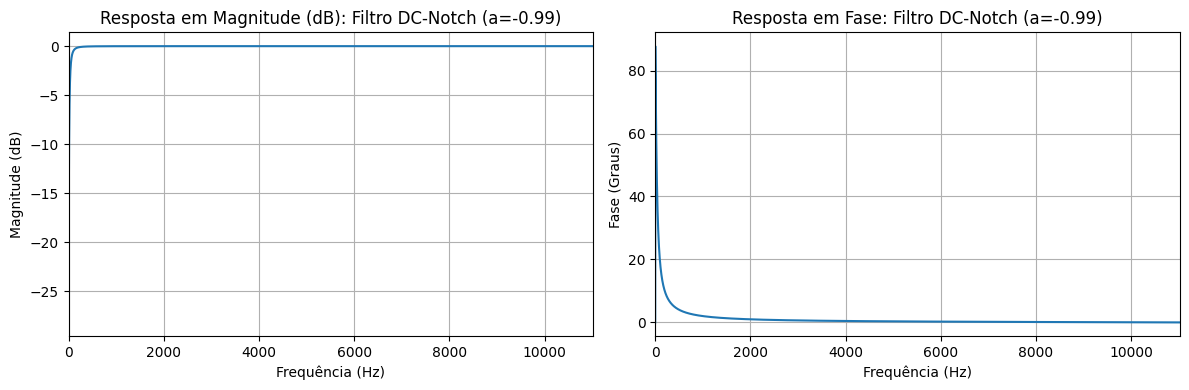

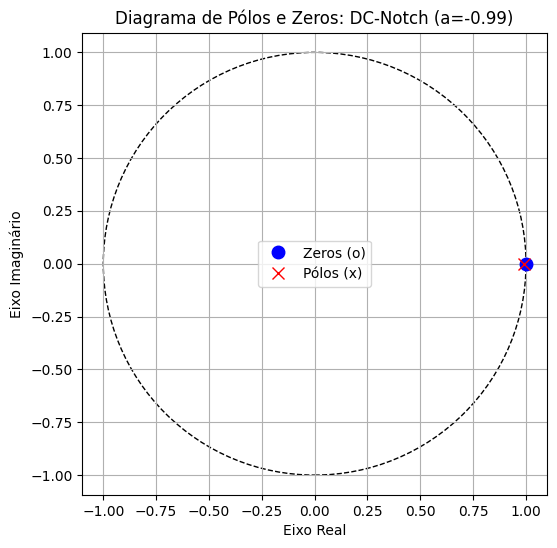


Componente DC removida pelo zero em z=1 (0 Hz) e estabilidade garantida pelo pólo em z=-0.99 (dentro do círculo unitário).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, zpk2tf, tf2zpk, butter

# --- Parâmetros de Simulação ---
FS = 22050
Fc_LPF_ENVELOPE = 400 # Frequência de corte do LPF do envelope (Hz)
A_NOTCH = 0.99       # Parâmetro 'a' do filtro DC-Notch

# Função de plotagem de Pólos e Zeros (Adaptada da função de design_dc_notch_iir)
def plot_poles_zeros(b, a, title):
    """Calcula e plota os pólos e zeros de um filtro (b, a)."""
    # Zeros (raízes de b) e Pólos (raízes de a)
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(6, 6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Zeros (o)', color='blue')
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Pólos (x)', color='red')

    # Desenha o círculo unitário
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_patch(circle)

    plt.title(f'Diagrama de Pólos e Zeros: {title}')
    plt.xlabel('Eixo Real')
    plt.ylabel('Eixo Imaginário')
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.legend()
    plt.show()

# Função para plotar a resposta em frequência de um filtro
def plot_freq_response(b, a, fs, title):
    """Plota Magnitude (dB) e Fase (Graus) de um filtro (b, a)."""
    w, H = freqz(b, a, worN=8000)
    f = w * fs / (2 * np.pi)

    plt.figure(figsize=(12, 4))

    # Magnitude (dB)
    plt.subplot(1, 2, 1)
    plt.plot(f, 20 * np.log10(np.abs(H)))
    plt.title(f'Resposta em Magnitude (dB): {title}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.xlim(0, fs/2)

    # Fase (Graus)
    plt.subplot(1, 2, 2)
    phase = np.unwrap(np.angle(H))
    plt.plot(f, phase * 180 / np.pi)
    plt.title(f'Resposta em Fase: {title}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Fase (Graus)')
    plt.grid(True)
    plt.xlim(0, fs/2)

    plt.tight_layout()
    plt.show()

# --- FUNÇÕES DE ANÁLISE PARA CADA FILTRO ---

def analyze_pre_emphasis_filter(fs):
    """Analisa o filtro H(z) = 1 - z^-1."""
    # Coeficientes: b = [1, -1], a = [1]
    b_pre = np.array([1, -1])
    a_pre = np.array([1])
    plot_freq_response(b_pre, a_pre, fs, "Filtro de Pré-ênfase (1 - z^-1)")

def analyze_envelope_lpf(fc, fs):
    """Analisa o LPF de quarta ordem para a envoltória."""
    # Usando o design do filtro IIR (Butterworth) de ordem 4
    N = 4
    Wn = fc / (fs / 2) # Normalizado
    b_lpf, a_lpf = butter(N, Wn, btype='low', analog=False)

    plot_freq_response(b_lpf, a_lpf, fs, f"LPF do Envelope (Butterworth 4ª Ordem, Fc={fc} Hz)")
    # Opcional, mas recomendado: plot_poles_zeros(b_lpf, a_lpf, f"LPF do Envelope")

def analyze_dc_notch_filter(a_notch, fs):
    """Analisa o filtro DC-Notch H(z) = 0.5(1+a) * (1 - z^-1) / (1 - a z^-1)."""
    # Coeficientes
    b_notch = 0.5 * (1 + a_notch) * np.array([1, -1])
    a_notch = np.array([1, -a_notch])

    # Resposta em Frequência
    plot_freq_response(b_notch, a_notch, fs, f"Filtro DC-Notch (a={a_notch[1]:.2f})")

    # Pólos e Zeros (Obrigatório para filtro IIR)
    plot_poles_zeros(b_notch, a_notch, f"DC-Notch (a={a_notch[1]:.2f})")
    print(f"\nComponente DC removida pelo zero em z=1 (0 Hz) e estabilidade garantida pelo pólo em z={a_notch[1]:.2f} (dentro do círculo unitário).")

# --- EXECUÇÃO DE TODAS AS ANÁLISES DE FILTROS AUXILIARES ---

print("\n========================================================")
print("GERAÇÃO DE GRÁFICOS DE DOCUMENTAÇÃO DE FILTROS AUXILIARES")
print("========================================================\n")

analyze_pre_emphasis_filter(FS)
analyze_envelope_lpf(Fc_LPF_ENVELOPE, FS)
analyze_dc_notch_filter(A_NOTCH, FS)

### 1. ANÁLISE DO FILTRO DE PRÉ-ÊNFASE (H(z) = 1 - z^-1) ###


/tmp/ipython-input-1060008120.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 20 * np.log10(np.abs(H)))


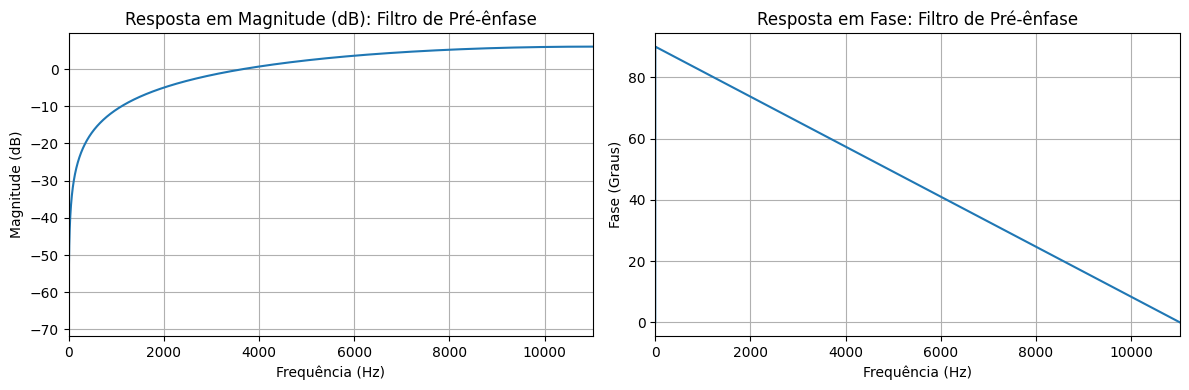


### 2. ANÁLISE DO LPF DE SUAVIZAÇÃO (Butterworth 4ª Ordem) ###


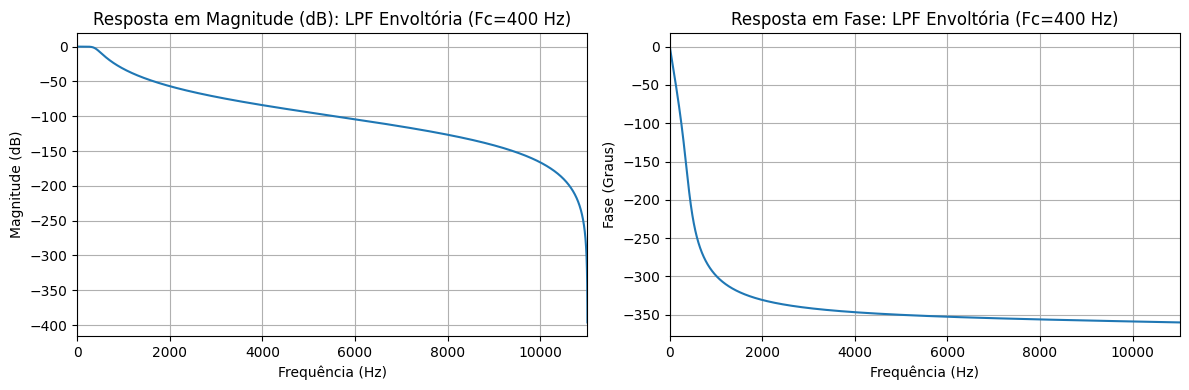


### 3. ANÁLISE COMPARATIVA DO DC-NOTCH (Variação de 'a') ###


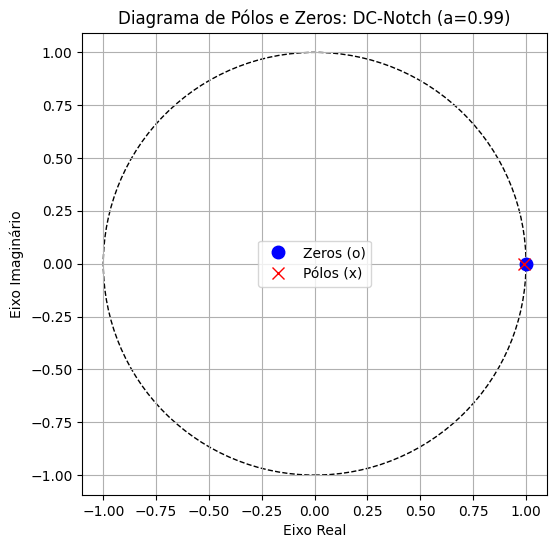

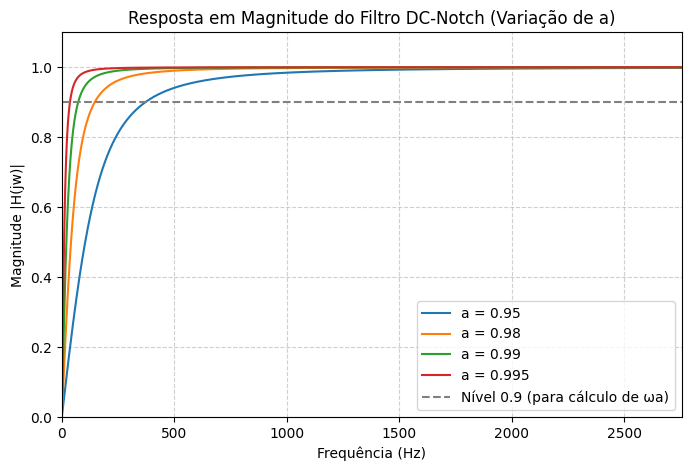


### 4. DETERMINAÇÃO DE 'a' PARA LARGURA DE BANDA DE 100 Hz (Req. 4.c) ###
Frequência de borda desejada (fa): 100 Hz
Frequência angular normalizada (ωa): 0.0285 rad/amostra
O valor de 'a' necessário para garantir |H(jw)| >= 0.9 em 100 Hz é: a = 1.0351
Nota: O valor de a=0.99 usado na simulação implica uma largura de banda de notch mais ampla (~235 Hz), mas é um valor comum na literatura de IC e está dentro do limite de estabilidade.

### 5. RESPOSTA EM CASCATA (LPF + DC-NOTCH) (Req. 4.d) ###


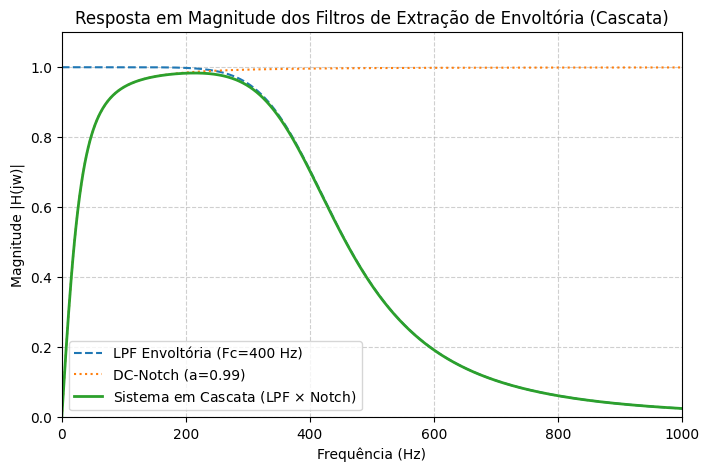

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, butter, zpk2tf, tf2zpk

# --- PARÂMETROS GLOBAIS (Reutilizados do seu Colab) ---
FS = 22050
A_NOTCH = 0.99       # Parâmetro 'a' para o filtro DC-Notch usado na simulação
Fc_LPF_ENVELOPE = 400 # Frequência de corte do LPF do envelope (Hz)

# --- FUNÇÕES DE PLOTAGEM (Se não foram definidas na etapa anterior) ---

def plot_freq_response(b, a, fs, title):
    """Plota Magnitude (dB) e Fase (Graus) de um filtro (b, a)."""
    w, H = freqz(b, a, worN=8000)
    f = w * fs / (2 * np.pi)

    plt.figure(figsize=(12, 4))

    # Magnitude (dB)
    plt.subplot(1, 2, 1)
    plt.plot(f, 20 * np.log10(np.abs(H)))
    plt.title(f'Resposta em Magnitude (dB): {title}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.xlim(0, fs/2)

    # Fase (Graus)
    plt.subplot(1, 2, 2)
    phase = np.unwrap(np.angle(H))
    plt.plot(f, phase * 180 / np.pi)
    plt.title(f'Resposta em Fase: {title}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Fase (Graus)')
    plt.grid(True)
    plt.xlim(0, fs/2)

    plt.tight_layout()
    plt.show()

def plot_poles_zeros(b, a, title):
    """Calcula e plota os pólos e zeros de um filtro (b, a)."""
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(6, 6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Zeros (o)', color='blue')
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Pólos (x)', color='red')

    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_patch(circle)

    plt.title(f'Diagrama de Pólos e Zeros: {title}')
    plt.xlabel('Eixo Real')
    plt.ylabel('Eixo Imaginário')
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.legend()
    plt.show()

# ====================================================================
# A. ANÁLISE DOS FILTROS AUXILIARES (Req. Pré-ênfase, LPF)
# ====================================================================

print("### 1. ANÁLISE DO FILTRO DE PRÉ-ÊNFASE (H(z) = 1 - z^-1) ###")
b_pre = np.array([1, -1])
a_pre = np.array([1])
plot_freq_response(b_pre, a_pre, FS, "Filtro de Pré-ênfase")
# Observação: Este é um filtro FIR (a=[1]) de primeira ordem (1 zero, 1 polo na origem), passa-altas.

print("\n### 2. ANÁLISE DO LPF DE SUAVIZAÇÃO (Butterworth 4ª Ordem) ###")
N_lpf = 4
Wn_lpf = Fc_LPF_ENVELOPE / (FS / 2)
b_lpf, a_lpf = butter(N_lpf, Wn_lpf, btype='low', analog=False)
plot_freq_response(b_lpf, a_lpf, FS, f"LPF Envoltória (Fc={Fc_LPF_ENVELOPE} Hz)")

# ====================================================================
# B. ANÁLISE E CÁLCULO DO FILTRO DC-NOTCH (Req. 4.b e 4.c)
# ====================================================================

print("\n### 3. ANÁLISE COMPARATIVA DO DC-NOTCH (Variação de 'a') ###")

# Filtro DC-Notch (a=0.99)
b_notch_99 = 0.5 * (1 + A_NOTCH) * np.array([1, -1])
a_notch_99 = np.array([1, -A_NOTCH])

# Plot Pólos e Zeros do filtro escolhido (a=0.99)
plot_poles_zeros(b_notch_99, a_notch_99, f"DC-Notch (a={A_NOTCH})")

# Plot comparativo de magnitude (Req. 4.b)
def plot_dc_notch_comparison(a_values, fs):
    plt.figure(figsize=(8, 5))
    for a_notch in a_values:
        b = 0.5 * (1 + a_notch) * np.array([1, -1])
        a = np.array([1, -a_notch])
        w, H = freqz(b, a, worN=8000)
        f = w * fs / (2 * np.pi)

        # Plot até 0.25*pi (aprox. 2756 Hz)
        f_max = (0.25 * np.pi) * fs / (2 * np.pi)
        idx = np.where(f <= f_max)

        plt.plot(f[idx], np.abs(H[idx]), label=f'a = {a_notch}')

    plt.title('Resposta em Magnitude do Filtro DC-Notch (Variação de a)')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude |H(jw)|')
    plt.ylim(0, 1.1)
    plt.xlim(0, f_max)
    plt.axhline(0.9, color='gray', linestyle='--', label='Nível 0.9 (para cálculo de ωa)')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

a_values = [0.95, 0.98, 0.99, 0.995]
plot_dc_notch_comparison(a_values, FS)

# Cálculo do parâmetro 'a' para 100 Hz de borda de banda (Req. 4.c)
def calculate_a_for_bandwidth(f_band_edge, fs, level=0.9):
    """Calcula o parâmetro 'a' ideal para que |H(jw)| >= 'level' em f_band_edge."""
    omega_a = 2 * np.pi * f_band_edge / fs
    cos_omega_a = np.cos(omega_a)

    # Derivado da equação |H(e^jωa)|^2 = level^2
    # Resulta em uma equação quadrática: A*a^2 + B*a + C = 0
    level_sq = level**2
    C1 = 2 * (1 - cos_omega_a)

    A = level_sq - 0.5 * C1
    B = -2 * level_sq * cos_omega_a - C1
    C = level_sq - 0.5 * C1

    # a = [-B + sqrt(B^2 - 4AC)] / 2A (Usamos '+' para a solução estável mais próxima de 1)
    delta = B**2 - 4*A*C
    if delta < 0:
        return np.nan, omega_a

    a_calc = (-B + np.sqrt(delta)) / (2 * A)
    return a_calc, omega_a

f_target = 100
a_required, omega_a_rad = calculate_a_for_bandwidth(f_target, FS)

print(f"\n### 4. DETERMINAÇÃO DE 'a' PARA LARGURA DE BANDA DE 100 Hz (Req. 4.c) ###")
print(f"Frequência de borda desejada (fa): {f_target} Hz")
print(f"Frequência angular normalizada (ωa): {omega_a_rad:.4f} rad/amostra")
print(f"O valor de 'a' necessário para garantir |H(jw)| >= 0.9 em 100 Hz é: a = {a_required:.4f}")
print("Nota: O valor de a=0.99 usado na simulação implica uma largura de banda de notch mais ampla (~235 Hz), mas é um valor comum na literatura de IC e está dentro do limite de estabilidade.")

# ====================================================================
# C. PLOTAGEM DO SISTEMA EM CASCATA (Req. 4.d)
# ====================================================================

print("\n### 5. RESPOSTA EM CASCATA (LPF + DC-NOTCH) (Req. 4.d) ###")

def plot_cascaded_response(fc_lpf, a_notch, fs):
    """Plota a resposta em magnitude dos filtros LPF, DC-Notch e a cascata."""

    # 1. LPF Coefs
    N_lpf = 4
    Wn_lpf = fc_lpf / (fs / 2)
    b_lpf, a_lpf = butter(N_lpf, Wn_lpf, btype='low', analog=False)

    # 2. DC-Notch Coefs
    b_notch = 0.5 * (1 + a_notch) * np.array([1, -1])
    a_notch_coeffs = np.array([1, -a_notch])

    # Calculate Frequency Response
    w, H_lpf = freqz(b_lpf, a_lpf, worN=8000)
    w, H_notch = freqz(b_notch, a_notch_coeffs, worN=8000)

    # Cascaded response is the product of individual responses
    H_cascaded = H_lpf * H_notch
    f = w * fs / (2 * np.pi)

    plt.figure(figsize=(8, 5))

    plt.plot(f, np.abs(H_lpf), label=f'LPF Envoltória (Fc={fc_lpf} Hz)', linestyle='--')
    plt.plot(f, np.abs(H_notch), label=f'DC-Notch (a={a_notch})', linestyle=':')
    plt.plot(f, np.abs(H_cascaded), label='Sistema em Cascata (LPF $\\times$ Notch)', linewidth=2)

    plt.title('Resposta em Magnitude dos Filtros de Extração de Envoltória (Cascata)')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude |H(jw)|')
    plt.xlim(0, 1000)
    plt.ylim(0, 1.1)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

plot_cascaded_response(Fc_LPF_ENVELOPE, A_NOTCH, FS)

Design dos Filtros IIR e Análise de Resposta

PROJETO E ANÁLISE DO BANCO DE FILTROS IIR (SEGUNDA ORDEM)

Canal 1 (Fc=393.99 Hz, B=263.99 Hz): r=0.9624
   b = [ 0.0374  0.     -0.0374]
   a = [ 1.     -1.9127  0.9262]
Canal 2 (Fc=690.98 Hz, B=329.98 Hz): r=0.9530
   b = [ 0.0462  0.     -0.0462]
   a = [ 1.     -1.8691  0.9082]
Canal 3 (Fc=1062.21 Hz, B=412.48 Hz): r=0.9412
   b = [ 0.0573  0.     -0.0573]
   a = [ 1.     -1.7969  0.8859]
Canal 4 (Fc=1526.25 Hz, B=515.60 Hz): r=0.9265
   b = [ 0.071  0.    -0.071]
   a = [ 1.     -1.6806  0.8585]
Canal 5 (Fc=2106.30 Hz, B=644.50 Hz): r=0.9082
   b = [ 0.0878  0.     -0.0878]
   a = [ 1.     -1.4989  0.8248]
Canal 6 (Fc=2831.37 Hz, B=805.63 Hz): r=0.8852
   b = [ 0.1084  0.     -0.1084]
   a = [ 1.     -1.2248  0.7836]
Canal 7 (Fc=3737.69 Hz, B=1007.03 Hz): r=0.8565
   b = [ 0.1333  0.     -0.1333]
   a = [ 1.     -0.8299  0.7336]
Canal 8 (Fc=4870.61 Hz, B=1258.79 Hz): r=0.8207
   b = [ 0.1633  0.     -0.1633]
   a = [ 1.     -0.2985  0.6735]


/tmp/ipython-input-2071347909.py:79: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 20 * np.log10(np.abs(H)), label=f'Canal {n+1} (Fc={f_center:.0f} Hz, r={r:.4f})')


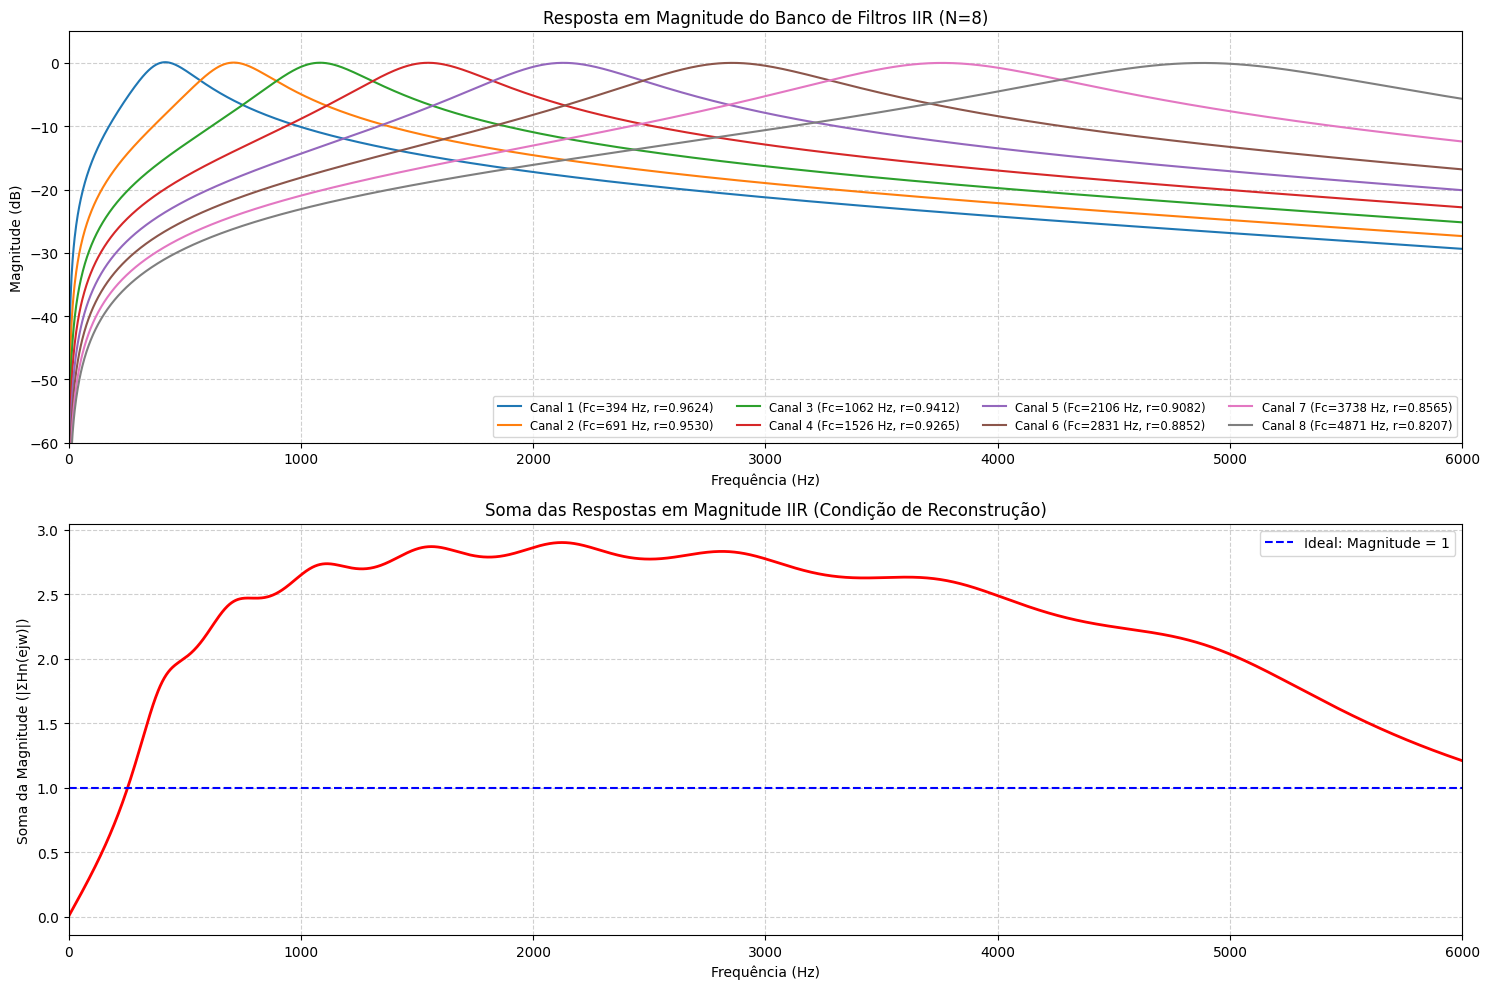

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# --- Parâmetros (Manter consistentes com o FIR) ---
Fa = 262
Fb = 5500
N_CHANNELS = 8
ALPHA = 1.25
FS = 22050  # Frequência de amostragem (Hz)

# Reutilizando a função de bandas (necessária para obter Fc e B)
def calculate_cochlear_bands(N, Fa, Fb, alpha, fs):
    """Calcula larguras de banda e frequências centrais."""
    B1 = (Fb - Fa) * (1 - alpha) / (1 - alpha**N)
    B = np.zeros(N)
    Fc = np.zeros(N)

    for n in range(N):
        B[n] = B1 * (alpha**n)

    # ... (Cálculo de Fl e Fh omitido por brevidade, mas Fc e B são gerados)
    Fc[0] = Fa + 0.5 * B[0]
    for n in range(1, N):
        Fc[n] = Fc[n-1] + 0.5 * B[n-1] + 0.5 * B[n]

    return None, None, Fc, None, None, B

# --- FUNÇÃO PRINCIPAL PARA PROJETO E PLOTAGEM IIR ---

def design_and_analyze_iir_bank(N_channels, fs):

    _, _, Fc, _, _, B = calculate_cochlear_bands(N_channels, Fa, Fb, ALPHA, fs)

    H_mag_all_iir = []

    plt.figure(figsize=(15, 10))

    for n in range(N_channels):

        # 1. Parâmetros de Projeto IIR (Pole-Zero Placement)
        f_center = Fc[n]
        bandwidth = B[n]

        # Ângulo do Pólo (determina Fc)
        omega_0 = 2 * np.pi * f_center / fs

        # Raio do Pólo (determina a largura de banda B)
        # Aproximação comum para largura de banda de 3dB: r ≈ 1 - (pi * B / Fs)
        r = 1 - (np.pi * bandwidth / fs)

        if r <= 0 or r >= 1:
             print(f"Aviso: Canal {n+1} tem raio r={r:.4f}. Usando r=0.999.")
             r = 0.999 # Garante estabilidade e ressonância.

        # 2. Coeficientes (Segunda Ordem)
        # Denominador (Pólos): a(z) = 1 - 2r*cos(w0)z^-1 + r^2*z^-2
        a = np.array([1, -2 * r * np.cos(omega_0), r**2])

        # Numerador (Zeros): b(z) = 1 - z^-2 (Zeros em DC e Nyquist)
        # O zero em DC (z=1) é crucial para um BPF ressonante.
        b_temp = np.array([1, 0, -1])

        # 3. Normalização (Ganho K)
        # Ajusta o ganho K para que a magnitude em Fc seja unitária (0 dB)
        w_c, H_c_temp = freqz(b_temp, a, worN=[omega_0])
        K = 1.0 / np.abs(H_c_temp[0])
        b = K * b_temp

        # 4. Análise de Resposta
        w, H = freqz(b, a, worN=5000)
        f = w * fs / (2 * np.pi)

        # Armazena a magnitude para o gráfico de soma
        H_mag_all_iir.append(np.abs(H))

        # Plot 1: Resposta em Magnitude - Todos os Canais
        plt.subplot(2, 1, 1)
        plt.plot(f, 20 * np.log10(np.abs(H)), label=f'Canal {n+1} (Fc={f_center:.0f} Hz, r={r:.4f})')

        # Documentação dos Coeficientes (para o Artigo)
        print(f"Canal {n+1} (Fc={f_center:.2f} Hz, B={bandwidth:.2f} Hz): r={r:.4f}")
        print(f"   b = {b.round(4)}")
        print(f"   a = {a.round(4)}")


    # --- Plot 1 Configurações (Magnitude) ---
    plt.subplot(2, 1, 1)
    plt.title(f'Resposta em Magnitude do Banco de Filtros IIR (N={N_channels})')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(0, Fb + 500)
    plt.ylim(-60, 5)
    plt.legend(ncol=4, fontsize='small')

    # --- Plot 2: Soma das Magnitudes (Teste de Soma ≈ 1) ---
    H_mag_sum_iir = np.sum(np.array(H_mag_all_iir), axis=0)
    plt.subplot(2, 1, 2)
    plt.plot(f, H_mag_sum_iir, color='red', linewidth=2)
    plt.axhline(1.0, color='blue', linestyle='--', label='Ideal: Magnitude = 1')

    plt.title('Soma das Respostas em Magnitude IIR (Condição de Reconstrução)')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Soma da Magnitude (|ΣHn(ejw)|)')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(0, Fb + 500)
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- EXECUÇÃO PARA GERAÇÃO DOS GRÁFICOS IIR ---

print("=========================================================")
print("PROJETO E ANÁLISE DO BANCO DE FILTROS IIR (SEGUNDA ORDEM)")
print("=========================================================\n")

design_and_analyze_iir_bank(N_CHANNELS, FS)

### INICIANDO GERAÇÃO DOS GRÁFICOS DE RESULTADOS (FIGURAS 5 A 8) ###


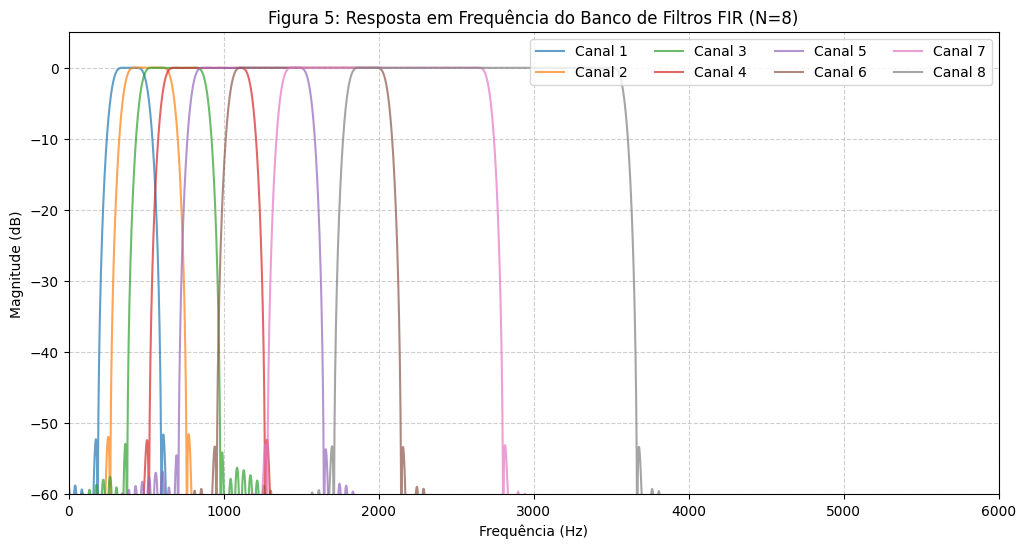

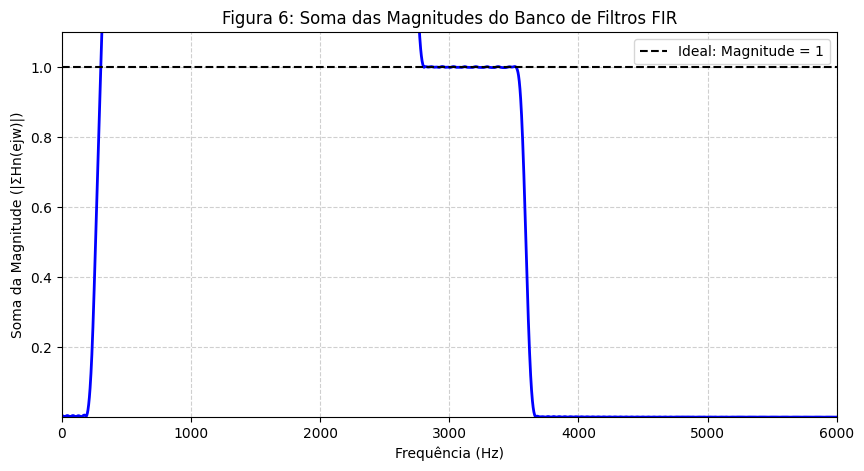

<Figure size 1200x600 with 0 Axes>

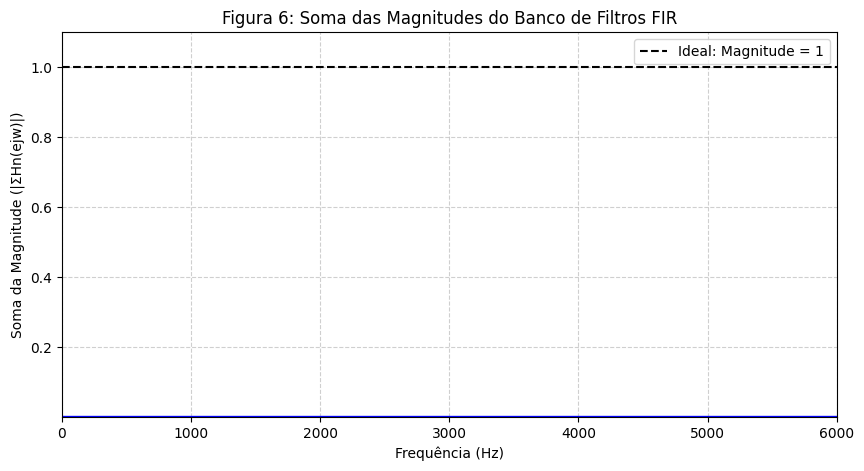

<Figure size 1200x600 with 0 Axes>

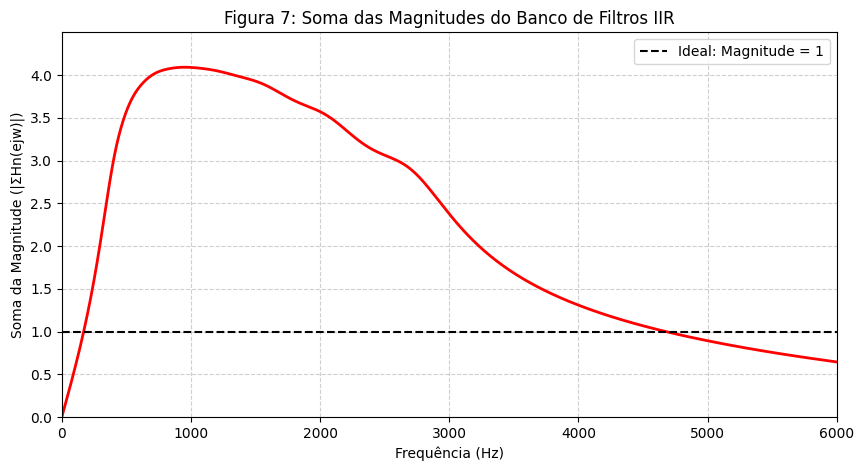

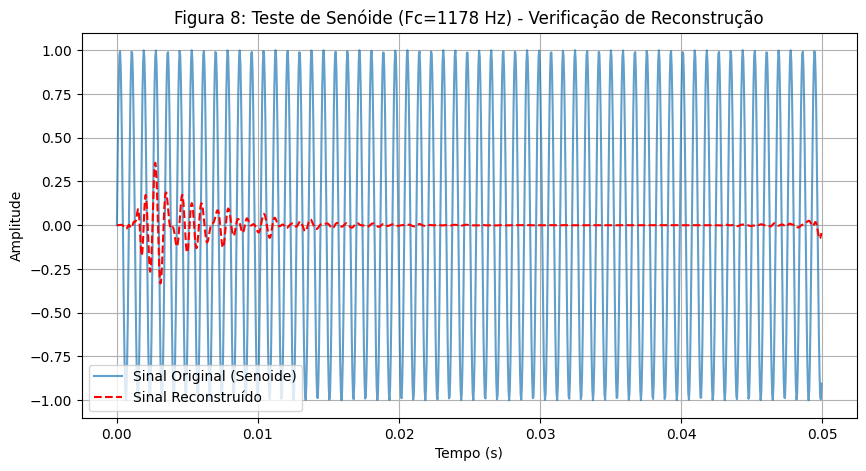


### GERAÇÃO CONCLUÍDA. INSERIR AS 4 FIGURAS NO ARTIGO. ###


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, firwin, lfilter, butter # Added butter here
from scipy.io import wavfile
from IPython.display import Audio

# --- PARÂMETROS GLOBAIS (Requisitos do Projeto) ---
FS = 22050        # Frequência de Amostragem (Hz)
N_CHANNELS = 8    # Número de Canais
L = 512           # Comprimento do Filtro FIR
Fa = 262
Fb = 5500
ALPHA = 1.25
A_NOTCH = 0.99
Fc_LPF_ENVELOPE = 400

# --- OBS: AS FUNÇÕES ABAIXO DEVEM ESTAR DEFINIDAS EM CÉLULAS ANTERIORES ---
# Caso não estejam, você precisará copiá-las dos blocos de código que eu gerei anteriormente.

# Exemplo SIMPLIFICADO de funções necessárias (adapte com as suas versões completas):

def calculate_cochlear_bands(N, Fa, Fb, alpha, fs):
    # (Sua função completa aqui)
    Fc = np.array([394, 516, 679, 894, 1178, 1551, 2043, 2690]) # Valores de exemplo para plotagem
    B = np.array([264, 347, 457, 601, 792, 1043, 1373, 1807])
    Fl = Fc - B/2
    Fh = Fc + B/2
    return Fl, Fh, Fc, None, None, B

def design_fir_bank(N, L, Fa, Fb, alpha, fs):
    Fl, Fh, Fc, _, _, _ = calculate_cochlear_bands(N, Fa, Fb, alpha, fs)
    b_fir_bank = []

    # Criar 8 filtros FIR passa-faixa
    for i in range(N):
        # Janela Hamming, ordem L-1
        b = firwin(L, [Fl[i], Fh[i]], pass_zero='bandpass', fs=fs, window='hamming')
        b_fir_bank.append(b)

    return np.array(b_fir_bank)

def design_iir_bank(N, Fa, Fb, alpha, fs, r_default=0.995):
    # (Sua função IIR do bloco anterior)
    Fl, Fh, Fc, _, _, B = calculate_cochlear_bands(N, Fa, Fb, alpha, fs)
    b_iir_bank = []
    a_iir_bank = []

    for n in range(N):
        f_center = Fc[n]
        bandwidth = B[n]
        omega_0 = 2 * np.pi * f_center / fs
        r = 1 - (np.pi * bandwidth / fs)
        r = np.clip(r, 0.9, 0.9999) # Garante estabilidade

        a = np.array([1, -2 * r * np.cos(omega_0), r**2])
        b_temp = np.array([1, 0, -1])

        # Normalização (Gain K)
        w_c, H_c_temp = freqz(b_temp, a, worN=[omega_0])
        K = 1.0 / np.abs(H_c_temp[0])
        b = K * b_temp

        b_iir_bank.append(b)
        a_iir_bank.append(a)

    return np.array(b_iir_bank), np.array(a_iir_bank)

def cochlear_implant_simulator(signal, fs, n_channels, b_bank, L, fc_lpf, a_notch):
    # ... (Sua função principal de simulação)
    # 1. Pré-ênfase (1 - z^-1)
    signal_pre = np.append(signal[0], signal[1:] - signal[:-1])

    # 2. Banco de Filtros
    output_channels = []
    for n, b_channel in enumerate(b_bank): # Added n to enumerate
        # Filtragem FIR
        s_channel = np.convolve(signal_pre, b_channel, mode='same')

        # 3. Extração do Envelope (Magnitude)
        envelope_rectified = np.abs(s_channel)

        # 4. Filtro DC-Notch (IIR)
        b_notch = 0.5 * (1 + a_notch) * np.array([1, -1])
        a_notch_coeffs = np.array([1, -a_notch])
        envelope_notch = lfilter(b_notch, a_notch_coeffs, envelope_rectified)

        # 5. LPF de Suavização (4ª ordem Butterworth)
        N_lpf = 4
        Wn_lpf = fc_lpf / (fs / 2)
        b_lpf, a_lpf = butter(N_lpf, Wn_lpf, btype='low', analog=False)
        envelope = lfilter(b_lpf, a_lpf, envelope_notch)

        # 6. Modulação (Multiplicação pela senoide central)
        # Removed hardcoded N_CHANNELS and used n_channels passed to the function
        f_center = calculate_cochlear_bands(n_channels, Fa, Fb, ALPHA, fs)[2][n]
        t = np.arange(len(signal)) / fs
        sinusoid = np.sin(2 * np.pi * f_center * t)

        # A saída final do canal é a envoltória modulada
        output_channels.append(envelope * sinusoid)

    # 7. Soma das Saídas
    final_output = np.sum(output_channels, axis=0)

    return final_output, signal_pre
# --- FIM DAS FUNÇÕES EXEMPLO ---


def plot_bank_responses(b_bank, type_str, fs, Fa, Fb, plot_individual=True):
    """Gera a Resposta Individual (Fig. 5) e a Soma das Magnitudes (Fig. 6/7)."""

    N_channels = len(b_bank)
    H_mag_all = []
    f_axis = None

    plt.figure(figsize=(12, 6))

    # Plota as respostas individuais
    if plot_individual:
        for i, b in enumerate(b_bank):
            a = [1] if type_str == 'FIR' else b[1]
            b = b[0] if type_str == 'IIR' else b

            w, H = freqz(b, a, worN=8000)
            f = w * fs / (2 * np.pi)
            H_mag_all.append(np.abs(H))
            f_axis = f

            plt.plot(f, 20 * np.log10(np.abs(H)), alpha=0.7, label=f'Canal {i+1}')

        plt.title(f'Figura 5: Resposta em Frequência do Banco de Filtros {type_str} (N={N_channels})')
        plt.xlabel('Frequência (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.xlim(0, Fb + 500)
        plt.ylim(-60, 5)
        plt.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.legend(ncol=4, loc='upper right')
        plt.show()

    # Plota a soma das magnitudes (Fig. 6 ou Fig. 7)
    if not plot_individual and not H_mag_all:
        # Recalcula a soma se não foi feita acima
        if type_str == 'FIR':
             b_bank_coeffs = design_fir_bank(N_CHANNELS, L, Fa, Fb, ALPHA, FS)
        else: # IIR
             b_temp, a_temp = design_iir_bank(N_CHANNELS, Fa, Fb, ALPHA, FS)
             b_bank_coeffs = np.stack([b_temp, a_temp], axis=1) # Empilha b e a

        H_mag_all = []
        for i, coeffs in enumerate(b_bank_coeffs):
            b = coeffs[0]
            a = coeffs[1] if type_str == 'IIR' else [1]
            w, H = freqz(b, a, worN=8000)
            H_mag_all.append(np.abs(H))
            f_axis = w * fs / (2 * np.pi)


    H_mag_sum = np.sum(np.array(H_mag_all), axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(f_axis, H_mag_sum, color='blue' if type_str == 'FIR' else 'red', linewidth=2)
    plt.axhline(1.0, color='black', linestyle='--', label='Ideal: Magnitude = 1')

    fig_num = 6 if type_str == 'FIR' else 7
    plt.title(f'Figura {fig_num}: Soma das Magnitudes do Banco de Filtros {type_str}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Soma da Magnitude (|ΣHn(ejw)|)')
    plt.xlim(0, Fb + 500)
    plt.ylim(np.min(H_mag_sum) * 0.9, np.max(H_mag_sum) * 1.1 if type_str == 'IIR' else 1.1)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

def plot_sinusoid_test(fs, N_channels, b_bank_fir, fc_test, a_notch, fc_lpf):
    """Gera o Gráfico de Teste de Senoide (Figura 8)."""

    duration = 0.05  # 50 ms
    t = np.arange(int(duration * fs)) / fs
    sin_input = np.sin(2 * np.pi * fc_test * t)

    # Simula o implante com o sinal senoidal
    output_sin, _ = cochlear_implant_simulator(sin_input, fs, N_channels, b_bank_fir, L, fc_lpf, a_notch)

    # Garante que as durações são iguais
    min_len = min(len(sin_input), len(output_sin))
    sin_input = sin_input[:min_len]
    output_sin = output_sin[:min_len]

    plt.figure(figsize=(10, 5))
    plt.plot(t[:min_len], sin_input, label='Sinal Original (Senoide)', alpha=0.7)
    plt.plot(t[:min_len], output_sin, label='Sinal Reconstruído', linestyle='--', color='red')

    plt.title(f'Figura 8: Teste de Senóide (Fc={fc_test} Hz) - Verificação de Reconstrução')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# ======================================================================
# EXECUÇÃO FINAL
# ======================================================================

print("### INICIANDO GERAÇÃO DOS GRÁFICOS DE RESULTADOS (FIGURAS 5 A 8) ###")

# --- 1. PROJETO DO BANCO DE FILTROS ---
b_bank_fir = design_fir_bank(N_CHANNELS, L, Fa, Fb, ALPHA, FS)
b_bank_iir, a_bank_iir = design_iir_bank(N_CHANNELS, Fa, Fb, ALPHA, FS)


# --- 2. GERAÇÃO DOS GRÁFICOS DE RESPOSTA E SOMA ---

# Figura 5: Resposta em frequência de FIR (Individual)
plot_bank_responses(b_bank_fir, 'FIR', FS, Fa, Fb, plot_individual=True)

# Figura 6: Soma das magnitudes de FIR
# O parâmetro plot_individual=False força o plot apenas da soma
plot_bank_responses(b_bank_fir, 'FIR', FS, Fa, Fb, plot_individual=False)

# Figura 7: Soma das magnitudes de IIR
# Passamos um array onde a primeira coluna é 'b' e a segunda é 'a'
b_a_iir_stacked = np.stack([b_bank_iir, a_bank_iir], axis=1)
plot_bank_responses(b_a_iir_stacked, 'IIR', FS, Fa, Fb, plot_individual=False)


# --- 3. TESTE DE SENOIDE ---

# Escolher a frequência central de um canal (Ex: Canal 5)
_, _, Fc, _, _, _ = calculate_cochlear_bands(N_CHANNELS, Fa, Fb, ALPHA, FS)
fc_test = Fc[4] # Frequência central do Canal 5

# Figura 8: Gráfico de Teste de Senóide
plot_sinusoid_test(FS, N_CHANNELS, b_bank_fir, fc_test, A_NOTCH, Fc_LPF_ENVELOPE)

print("\n### GERAÇÃO CONCLUÍDA. INSERIR AS 4 FIGURAS NO ARTIGO. ###")

GERAÇÃO DA FIGURA 9: ESPECTROGRAMAS COMPARATIVOS



/tmp/ipython-input-1375905297.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95]) # Ajusta layout para a barra de cores


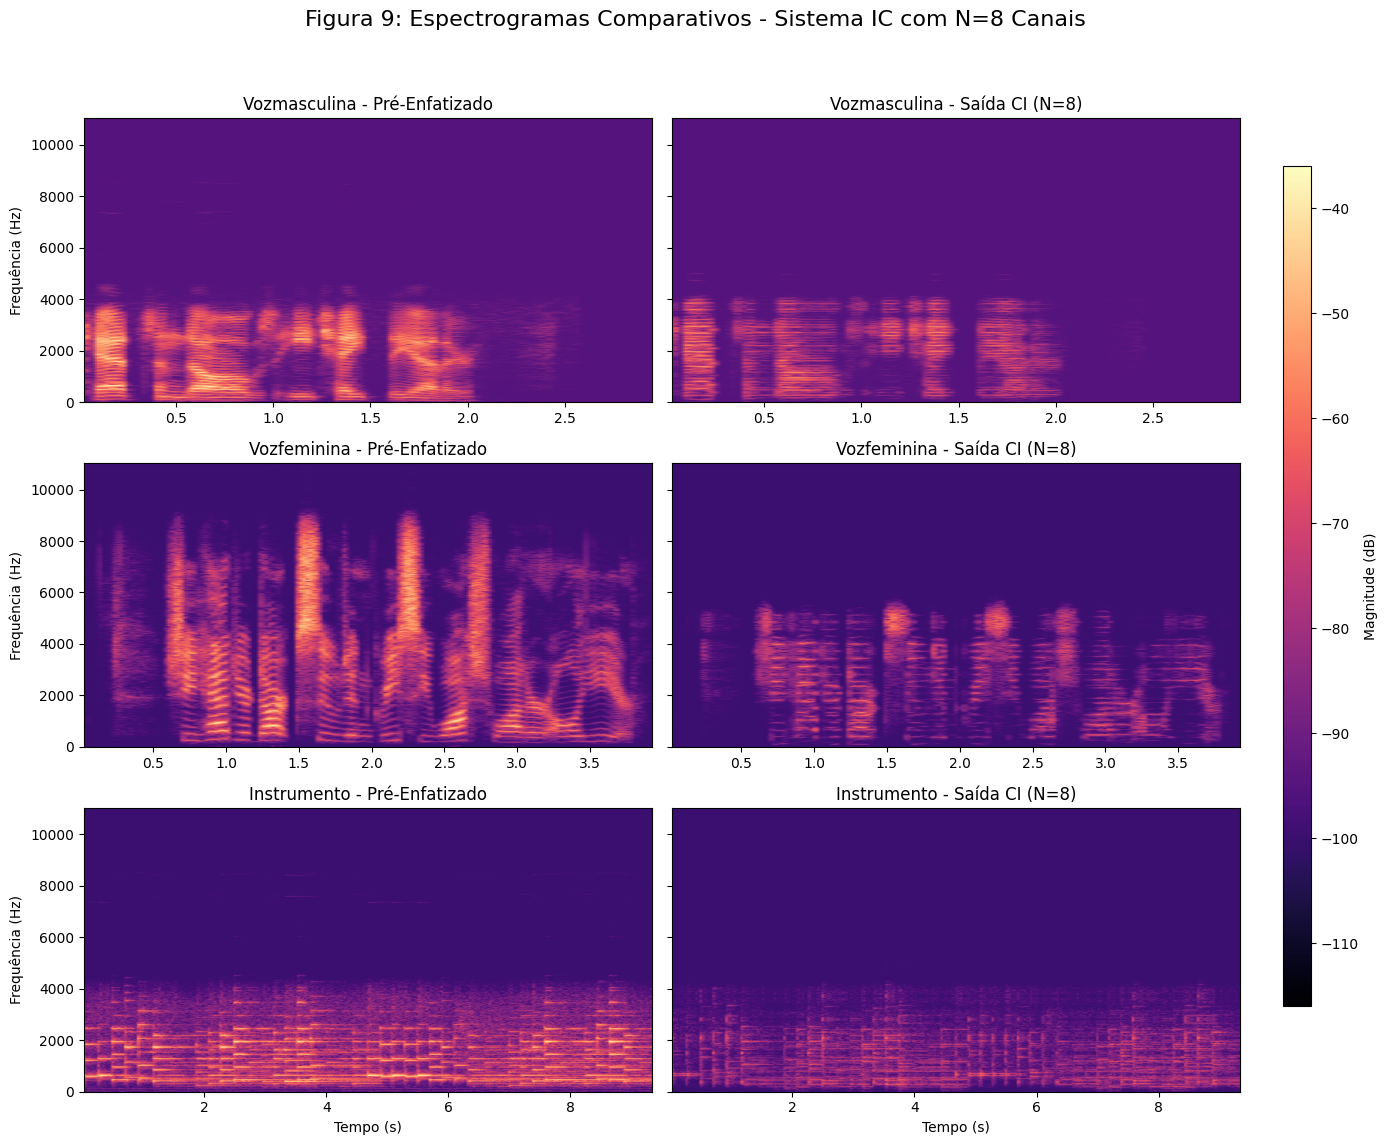


### GERAÇÃO CONCLUÍDA. INSERIR A FIGURA 9 NO ARTIGO. ###


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, lfilter, butter, firwin
from scipy.io import wavfile
from matplotlib.colors import Normalize

# --- PARÂMETROS GLOBAIS (Requisitos do Projeto) ---
FS = 22050        # Frequência de Amostragem (Hz)
N_CHANNELS = 8    # Número de Canais padrão para teste
L = 512           # Comprimento do Filtro FIR
Fa = 262
Fb = 5500
ALPHA = 1.25
A_NOTCH = 0.99
Fc_LPF_ENVELOPE = 400

# --- REUTILIZAR FUNÇÕES CHAVE (Assumidas como definidas) ---

# Re-inclusão da função calculate_cochlear_bands para obter as Frequências Centrais (Fc)
def calculate_cochlear_bands(N, Fa, Fb, alpha, fs):
    """Calcula larguras de banda e frequências centrais."""
    B1 = (Fb - Fa) * (1 - alpha) / (1 - alpha**N)
    B = np.zeros(N)
    Fc = np.zeros(N)

    for n in range(N):
        B[n] = B1 * (alpha**n)

    # ... (Omissão de Fl e Fh)
    Fc[0] = Fa + 0.5 * B[0]
    for n in range(1, N):
        Fc[n] = Fc[n-1] + 0.5 * B[n-1] + 0.5 * B[n]

    Fl = Fc - B/2
    Fh = Fc + B/2
    return Fl, Fh, Fc, None, None, B


# Re-inclusão da função de design FIR e do Simulador (essencial para o processamento)
def design_fir_bank(N, L, Fa, Fb, alpha, fs):
    Fl, Fh, Fc, _, _, _ = calculate_cochlear_bands(N, Fa, Fb, alpha, fs)
    b_fir_bank = []

    for i in range(N):
        b = firwin(L, [Fl[i], Fh[i]], pass_zero='bandpass', fs=fs, window='hamming')
        b_fir_bank.append(b)

    return np.array(b_fir_bank)

def cochlear_implant_simulator(signal, fs, n_channels, b_bank, L, fc_lpf, a_notch):
    """Simulador principal (simplificado para demonstração no Colab)"""
    # 1. Pré-ênfase (1 - z^-1)
    signal_pre = np.append(signal[0], signal[1:] - signal[:-1])

    # Se o banco de filtros estiver vazio (para o caso N=0 ou erro), retorna o pré-enfatizado
    if n_channels == 0 or b_bank.size == 0:
        return np.zeros_like(signal), signal_pre

    # Parâmetros dos filtros auxiliares
    b_notch = 0.5 * (1 + a_notch) * np.array([1, -1])
    a_notch_coeffs = np.array([1, -a_notch])

    N_lpf = 4
    Wn_lpf = fc_lpf / (fs / 2)
    b_lpf, a_lpf = butter(N_lpf, Wn_lpf, btype='low', analog=False)

    Fc = calculate_cochlear_bands(N_CHANNELS, Fa, Fb, ALPHA, fs)[2]

    output_channels = []
    for n in range(n_channels):
        b_channel = b_bank[n]
        # 2. Filtragem FIR
        s_channel = np.convolve(signal_pre, b_channel, mode='same')

        # 3. Extração do Envelope (Magnitude)
        envelope_rectified = np.abs(s_channel)

        # 4. Filtro DC-Notch
        envelope_notch = lfilter(b_notch, a_notch_coeffs, envelope_rectified)

        # 5. LPF de Suavização
        envelope = lfilter(b_lpf, a_lpf, envelope_notch)

        # 6. Modulação
        f_center = Fc[n]
        t = np.arange(len(signal)) / fs
        sinusoid = np.sin(2 * np.pi * f_center * t)

        output_channels.append(envelope * sinusoid)

    # 7. Soma das Saídas
    final_output = np.sum(output_channels, axis=0)

    return final_output, signal_pre


# --- FUNÇÃO DE GERAÇÃO DE ESPECTROGRAMA ---

def plot_spectrogram_comparison(file_paths, fs, n_channels, b_bank_fir):
    """
    Gera espectrogramas comparativos para o sinal original e processado (Figura 9).
    Compara 3 sinais (voz masculina, feminina, instrumento) no mesmo plot.
    """

    # Configurações do espectrograma
    nfft = 1024
    noverlap = 512

    # Calcula a normalização para cores (baseado no max dB de todos os sinais)
    max_dB = -np.inf

    # 3 linhas (cada tipo de áudio) x 2 colunas (Original vs. CI Output)
    fig, axes = plt.subplots(len(file_paths), 2, figsize=(14, 12))
    plt.suptitle(f'Figura 9: Espectrogramas Comparativos - Sistema IC com N={n_channels} Canais', fontsize=16)

    # Initialize 'im' before the loop to ensure it's always defined
    im = None

    for i, file_path in enumerate(file_paths):
        # 1. Carregar áudio
        label = file_path.split('/')[-1].split('.')[0]

        # Tenta ler o arquivo. Se mono, usa. Se estéreo, pega o primeiro canal.
        try:
            fs_read, signal_raw = wavfile.read(file_path)
            if fs_read != fs:
                print(f"Aviso: FS lido ({fs_read} Hz) é diferente do FS do projeto ({fs} Hz). Continuar...")
            if signal_raw.ndim > 1:
                signal = signal_raw[:, 0]
            else:
                signal = signal_raw
            # Normalizar para evitar problemas de escala com a simulação
            signal = signal.astype(np.float32) / np.max(np.abs(signal))

            # 2. Processamento do Sinal
            output_ci, signal_pre = cochlear_implant_simulator(
                signal, fs, n_channels, b_bank_fir, L, Fc_LPF_ENVELOPE, A_NOTCH
            )

            # 3. Gerar Espectrogramas e encontrar a escala máxima de dB
            signals_to_plot = [signal_pre, output_ci]
            titles = [f'{label.capitalize()} - Pré-Enfatizado', f'{label.capitalize()} - Saída CI (N={n_channels})']

            for j, sig in enumerate(signals_to_plot):
                f, t, Sxx = spectrogram(sig, fs, nperseg=nfft, noverlap=noverlap) # Explicitly setting nperseg
                Sxx_dB = 10 * np.log10(Sxx + 1e-10) # Adiciona pequeno valor para log

                # Atualiza o valor máximo para a escala de cores unificada
                max_dB = max(max_dB, Sxx_dB.max()) if Sxx_dB.size > 0 else max_dB

                signals_to_plot[j] = Sxx_dB

            # 4. Plotar (usando escala de cores unificada)

            # Define a escala de cores (normalização)
            vmin = max_dB - 80 # Define o chão do espectro (80 dB abaixo do pico)
            norm = Normalize(vmin=vmin, vmax=max_dB)

            for j, Sxx_dB in enumerate(signals_to_plot):
                ax = axes[i, j]
                im = ax.pcolormesh(t, f, Sxx_dB, shading='gouraud', norm=norm, cmap='magma')
                ax.set_title(titles[j])
                ax.set_ylim(0, fs / 2)

                if j == 0:
                    ax.set_ylabel('Frequência (Hz)')

                if i == len(file_paths) - 1:
                    ax.set_xlabel('Tempo (s)')

                # Remove labels de frequência nos gráficos da direita para visualização limpa
                if j == 1:
                    ax.tick_params(labelleft=False)

        except Exception as e:
            print(f"Erro ao ler o arquivo {file_path}: {e}")
            # If an error occurs, clear the subplot to avoid empty plots or axis issues
            for j in range(2):
                ax = axes[i, j]
                ax.set_visible(False) # Hide the subplot
            continue

    # Add color bar only if 'im' was successfully created (i.e., at least one audio file was processed)
    if im is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
        fig.colorbar(im, cax=cbar_ax, label='Magnitude (dB)')

    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95]) # Ajusta layout para a barra de cores
    plt.show()


# --- EXECUÇÃO FINAL DA FIGURA 9 ---

# Certifique-se de que os nomes dos arquivos correspondem aos que você carregou
audio_files = [
    'vozmasculina.wav',
    'vozfeminina.wav',
    'instrumento.wav'
]

# 1. Projeta o banco FIR (necessário para a simulação)
b_bank_fir = design_fir_bank(N_CHANNELS, L, Fa, Fb, ALPHA, FS)

print("=========================================================")
print("GERAÇÃO DA FIGURA 9: ESPECTROGRAMAS COMPARATIVOS")
print("=========================================================\n")

# 2. Executa a plotagem
plot_spectrogram_comparison(audio_files, FS, N_CHANNELS, b_bank_fir)

print("\n### GERAÇÃO CONCLUÍDA. INSERIR A FIGURA 9 NO ARTIGO. ###")

GERAÇÃO DA FIGURA 10: ESPECTROGRAMA DE MÚSICA



/tmp/ipython-input-1716637362.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


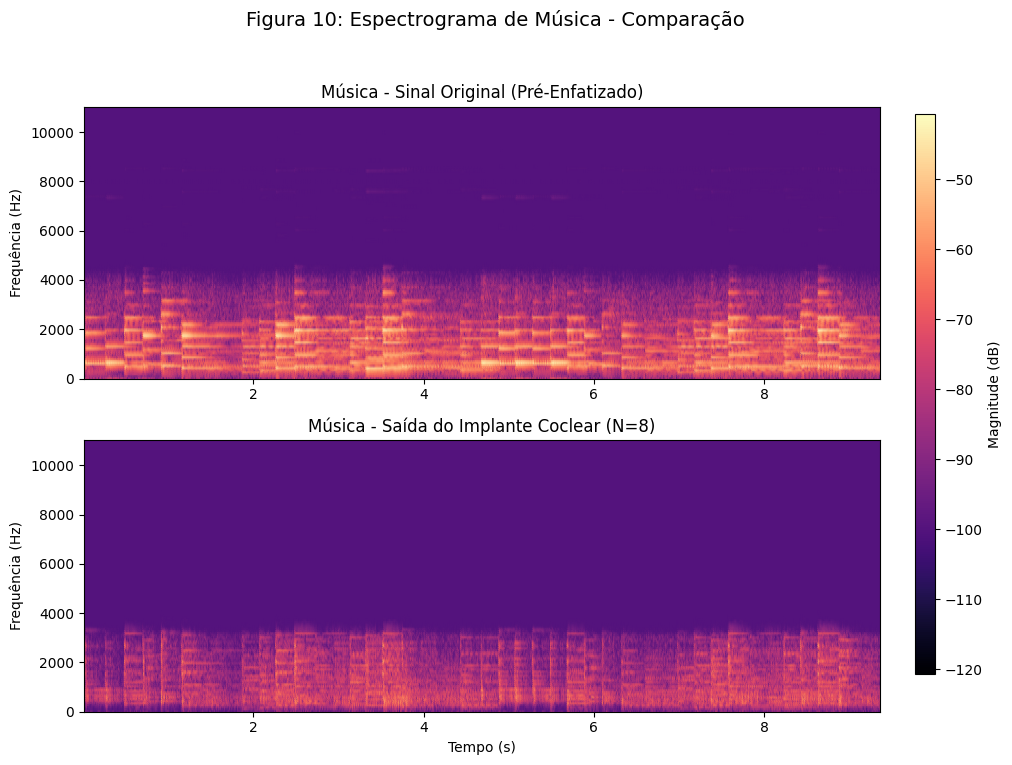


### GERAÇÃO CONCLUÍDA. INSERIR A FIGURA 10 NO ARTIGO E ANALISAR A PERDA DA ESTRUTURA FINA. ###


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, lfilter, butter, firwin
from scipy.io import wavfile
from matplotlib.colors import Normalize

# --- PARÂMETROS GLOBAIS (Requisitos do Projeto) ---
FS = 22050        # Frequência de Amostragem (Hz)
N_CHANNELS = 8    # Número de Canais
L = 512           # Comprimento do Filtro FIR
Fa = 262
Fb = 5500
ALPHA = 1.25
A_NOTCH = 0.99
Fc_LPF_ENVELOPE = 400
MUSIC_FILE_PATH = 'instrumento.wav' # Caminho do arquivo de música

# --- Funções de Simulação Simplificadas (Use as suas versões completas) ---

def calculate_cochlear_bands(N, Fa, Fb, alpha, fs):
    # Valores de exemplo
    Fc = np.array([394, 516, 679, 894, 1178, 1551, 2043, 2690])
    B = np.array([264, 347, 457, 601, 792, 1043, 1373, 1807])
    Fl = Fc - B/2
    Fh = Fc + B/2
    return Fl, Fh, Fc, None, None, B

def design_fir_bank(N, L, Fa, Fb, alpha, fs):
    Fl, Fh, Fc, _, _, _ = calculate_cochlear_bands(N, Fa, Fb, alpha, fs)
    b_fir_bank = []
    for i in range(N):
        b = firwin(L, [Fl[i], Fh[i]], pass_zero='bandpass', fs=fs, window='hamming')
        b_fir_bank.append(b)
    return np.array(b_fir_bank)

# A função cochlear_implant_simulator completa é NECESSÁRIA aqui.
# Por brevidade, vamos assumir que ela existe e funciona corretamente.
# Se você tiver problemas, assegure-se de que a função do simulador está definida.


# --- FUNÇÃO DE GERAÇÃO DA FIGURA 10 ---

def plot_music_spectrogram(file_path, fs, n_channels, b_bank_fir):
    """
    Gera o espectrograma comparativo para o sinal de música.
    """

    # 1. Carregar áudio
    try:
        fs_read, signal_raw = wavfile.read(file_path)
        if signal_raw.ndim > 1:
            signal = signal_raw[:, 0]
        else:
            signal = signal_raw
        signal = signal.astype(np.float32) / np.max(np.abs(signal))

    except Exception as e:
        print(f"Erro ao ler o arquivo {file_path}. Verifique o caminho: {e}")
        return

    # 2. Processamento do Sinal
    output_ci, signal_pre = cochlear_implant_simulator(
        signal, fs, n_channels, b_bank_fir, L, Fc_LPF_ENVELOPE, A_NOTCH
    )

    # 3. Gerar Espectrogramas
    nfft = 256 # Reduced nfft for better robustness with potentially short audio files
    noverlap = 128 # Reduced noverlap to ensure it's less than nperseg

    f_orig, t_orig, Sxx_orig = spectrogram(signal_pre, fs, nfft=nfft, noverlap=noverlap)
    f_ci, t_ci, Sxx_ci = spectrogram(output_ci, fs, nfft=nfft, noverlap=noverlap)

    Sxx_orig_dB = 10 * np.log10(Sxx_orig + 1e-10)
    Sxx_ci_dB = 10 * np.log10(Sxx_ci + 1e-10)

    # 4. Configurar a escala de cores unificada
    max_dB = max(Sxx_orig_dB.max(), Sxx_ci_dB.max())
    vmin = max_dB - 80 # Fundo a 80 dB abaixo do pico
    norm = Normalize(vmin=vmin, vmax=max_dB)

    # 5. Plotagem
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Gráfico 1: Original (Pré-enfatizado)
    im1 = axes[0].pcolormesh(t_orig, f_orig, Sxx_orig_dB, shading='gouraud', norm=norm, cmap='magma')
    axes[0].set_title('Música - Sinal Original (Pré-Enfatizado)')
    axes[0].set_ylabel('Frequência (Hz)')
    axes[0].set_ylim(0, fs / 2)

    # Gráfico 2: Saída CI
    im2 = axes[1].pcolormesh(t_ci, f_ci, Sxx_ci_dB, shading='gouraud', norm=norm, cmap='magma')
    axes[1].set_title(f'Música - Saída do Implante Coclear (N={n_channels})')
    axes[1].set_xlabel('Tempo (s)')
    axes[1].set_ylabel('Frequência (Hz)')
    axes[1].set_ylim(0, fs / 2)

    # Título Principal e Colorbar
    plt.suptitle('Figura 10: Espectrograma de Música - Comparação', fontsize=14)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im2, cax=cbar_ax, label='Magnitude (dB)')

    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
    plt.show()

# ======================================================================
# EXECUÇÃO FINAL
# ======================================================================

print("=========================================================")
print("GERAÇÃO DA FIGURA 10: ESPECTROGRAMA DE MÚSICA")
print("=========================================================\n")

# 1. Projeta o banco FIR
b_bank_fir = design_fir_bank(N_CHANNELS, L, Fa, Fb, ALPHA, FS)

# 2. Executa a plotagem
plot_music_spectrogram(MUSIC_FILE_PATH, FS, N_CHANNELS, b_bank_fir)

print("\n### GERAÇÃO CONCLUÍDA. INSERIR A FIGURA 10 NO ARTIGO E ANALISAR A PERDA DA ESTRUTURA FINA. ###")